# Deep Belief Modeling
Project for SI course

## Imports

In [12]:
import pickle
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from collections import Counter
from minisom import MiniSom
from copy import deepcopy

from preprocessing.vectors import prepare_dictionary,generate_vectors, find_close_words
from som.plot import plot_vectors
from preprocessing.article import random_percent
from model.features import f_importances
from preprocessing.article import word_preprocess

## Loading data

In [13]:
articles = pd.read_csv("resources/merged.csv", sep="\t")

## Input data visualisation

<AxesSubplot:title={'center':'Rozkład artykułów'}, xlabel='Rodzaj artykułów', ylabel='Liczba artykułów'>

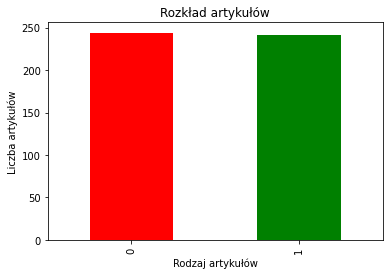

In [14]:
x = articles["label"].value_counts()
x.plot(kind="bar", color=["r", "g"],title="Rozkład artykułów",ylabel="Liczba artykułów",xlabel="Rodzaj artykułów")

## Text pre-processing for classification

In [15]:
print(articles["data"].head(10))
print(articles["data"].head(10).apply(word_preprocess))

0    It's been quite a week. I've been in the media...
1    This week has been eye-opening. Even for me --...
2    Yes, it's true. I beat COVID-19 in 48 hours wi...
3    The COVID-19 vaccines appear to be causing a g...
4    Back in the 1980s, I was a Columbia University...
5    So you got the vaccine because they told you t...
6    I Am A Living Proof That COVID-19 Is Fake This...
7    I have a PhD in virology and immunology. I’m a...
8    How do you convince the world’s population to ...
9    Take 15 minutes and listen to this interview w...
Name: data, dtype: object
0    [quite, week, medium, business, decade, never,...
1    [week, eye, opening, even, guy, warned, year, ...
2    [yes, true, beat, covid, hour, ivermectin, get...
3    [covid, vaccine, appear, causing, global, heal...
4    [back, columbia, university, student, learning...
5    [got, vaccine, told, get, forced, get, joe, bi...
6    [living, proof, covid, fake, unfiltered, take,...
7    [phd, virology, immunology, clinic

## Feature selection

### Pickle import

In [16]:
with open("models_storage/merged_csv_ms/vectorizer.pkl","rb") as file:
    tfidf_vectorizer = pickle.load(file)

with open("models_storage/merged_csv_ms/bow.pkl","rb") as file:
    tfidf_wm = pickle.load(file)

with open("models_storage/merged_csv_ms/classifier.pkl","rb") as file:
    sgdc_classifier = pickle.load(file)

with open("models_storage/merged_csv_ms/words_pa.pkl","rb") as file:
    words_pa = pickle.load(file)

tfidf_tokens = tfidf_vectorizer.get_feature_names_out()

print(tfidf_tokens)

df_tfidf_vect = pd.DataFrame(data=tfidf_wm.toarray(), columns=tfidf_tokens)

print("Tf-idf vectorizer")
print(df_tfidf_vect)


['aabduzrw' 'aaby' 'aadhaar' ... 'zoster' 'zuckerberg' 'zurich']
Tf-idf vectorizer
     aabduzrw  aaby  aadhaar  aafp  aaho  aamc  aamcnews  aap  aarogya  aaron  \
0    0.000000   0.0      0.0   0.0   0.0   0.0       0.0  0.0      0.0    0.0   
1    0.000000   0.0      0.0   0.0   0.0   0.0       0.0  0.0      0.0    0.0   
2    0.000000   0.0      0.0   0.0   0.0   0.0       0.0  0.0      0.0    0.0   
3    0.000000   0.0      0.0   0.0   0.0   0.0       0.0  0.0      0.0    0.0   
4    0.000000   0.0      0.0   0.0   0.0   0.0       0.0  0.0      0.0    0.0   
..        ...   ...      ...   ...   ...   ...       ...  ...      ...    ...   
383  0.000000   0.0      0.0   0.0   0.0   0.0       0.0  0.0      0.0    0.0   
384  0.000000   0.0      0.0   0.0   0.0   0.0       0.0  0.0      0.0    0.0   
385  0.000000   0.0      0.0   0.0   0.0   0.0       0.0  0.0      0.0    0.0   
386  0.000000   0.0      0.0   0.0   0.0   0.0       0.0  0.0      0.0    0.0   
387  0.055065   0.0      0

### Plots

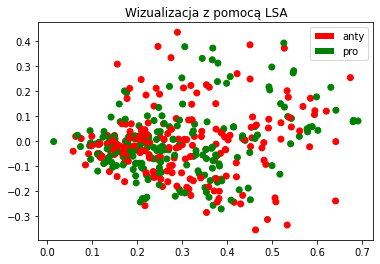

In [17]:
from matplotlib.patches import Patch

clftr = TruncatedSVD(2)
Xpca = clftr.fit_transform(tfidf_wm)
plt.title("Wizualizacja z pomocą LSA")

plt.scatter([x[0] for x in Xpca],[x[1] for x in Xpca],c=['r' if articles['label'][i] == 0 else 'g' for i,d in enumerate(Xpca)])
legend_elements = [Patch(facecolor='red', edgecolor='white',label='anty'),
                   Patch(facecolor='green', edgecolor='white',label='pro')]
plt.legend(handles=legend_elements, loc='upper right')
plt.show()

In [18]:
from sklearn.linear_model import SGDClassifier

h = .01
x_min, x_max = -0.4,0.6
y_min, y_max = -0.4,0.6
# loading dataset
X, y = tfidf_wm.toarray(), articles["label"]
# selecting first 2 components of PCA
X_selected = PCA(2).fit_transform(X)
# training classifier and evaluating on the whole plane
clf_sgd = SGDClassifier()
clf_sgd.fit(X_selected,y)

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

w = clf_sgd.coef_[0]
a = -w[0] / w[1]

margin = 1 / np.sqrt(np.sum(clf_sgd.coef_**2))
yy_down = yy - np.sqrt(1 + a**2) * margin
yy_up = yy + np.sqrt(1 + a**2) * margin

plt.plot(xx, yy_down, "k--")
plt.plot(xx, yy_up, "k--")

Z = clf_sgd.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.figure(figsize=(10,5))
plt.pcolormesh(xx, yy, Z, alpha=.6,cmap=cmap_light)
plt.title('Wizualizacja z pomocą PCA oraz SVC')
for xy,c in zip(X_selected,articles["label"]):
    plt.scatter(xy[0],xy[1],c= 'red' if c == 0 else 'green')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [388, 486]

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import svm
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

X, Y = tfidf_wm.toarray(), articles["label"]

X = PCA(2).fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

penalty = 5

clf = svm.SVC(kernel="linear", C=penalty)
clf.fit(x_train, y_train)

predicted = clf.predict(x_test)
print(confusion_matrix(y_test,predicted))
print(classification_report(y_test,predicted))
# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]

margin = 1 / np.sqrt(np.sum(clf.coef_**2))
yy_down = yy - np.sqrt(1 + a**2) * margin
yy_up = yy + np.sqrt(1 + a**2) * margin

plt.figure(1, figsize=(8, 8))
plt.clf()
plt.plot(xx, yy, "k-")
plt.plot(xx, yy_down, "k--")
plt.plot(xx, yy_up, "k--")

plt.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=80,
    facecolors="none",
    zorder=10,
    edgecolors="k",
    cmap=cm.get_cmap("RdYlGn"),
)
plt.scatter(
    X[:, 0], X[:, 1], c=Y, zorder=10, cmap=cm.get_cmap("RdYlGn"), edgecolors="k"
)

plt.axis("tight")
x_min = X[:, 0].min() - 0.1
x_max = X[:, 0].max() + 0.1
y_min = X[:, 1].min() - 0.1
y_max = X[:, 1].max() + 0.1

YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)


plt.contourf(XX, YY, Z, cmap=cm.get_cmap("RdBu"), alpha=0.5, linestyles=["-"])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())

plt.title('Wizualizacja z pomocą PCA oraz SVC')
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [388, 486]

### Key words

In [20]:
key_anti_words, key_pro_words = f_importances(sgdc_classifier.coef_,tfidf_tokens, limit=50)

pd.DataFrame(data={"PRO":[*zip(*key_pro_words)][1],"ANTI":[*zip(*key_anti_words)][1]},index=range(1,51))


PRO          ANTI
1     community         false
2        social           jab
3      nebraska     injection
4          time        report
5     advantage     treatment
6          cost        injury
7      infected  experimental
8         might          kill
9         covid     religious
10    immunised           big
11         rare        medium
12         risk     something
13     standard         wuhan
14         good        threat
15       chance       adverse
16    schaffner          incl
17        whole          case
18  participant    government
19       review           got
20         help      diabetes
21   recommends          ruby
22         care      tinnitus
23        fight         dobbs
24        cough           old
25   thimerosal          mass
26  vaccination          even
27     whooping        doctor
28        older          year
29      sarscov         blood
30         part       several
31  lichtenberg       article
32       travel        autism
33     approval  unvaccinated
34      getting       depends
35      disease     indicates
36       severe           eua
37    infection         heart
38     continue        number
39      protect        simply
40        trial          sick
41         dose       product
42      moderna       believe
43        gacvs      fatality
44      corbett        belief
45          get         brain
46          say        vessel
47         safe           aid
48        polio        though
49    effective         pilot
50      vaccine       mandate

### Article vectors

In [21]:
key_words = [s for _,s in key_pro_words+key_anti_words]
article_vectors = []

for a in words_pa:
    zliczone = Counter([word for word in a if word in key_words])
    article_vectors.append([zliczone[s] for s in key_words])

article_vectors = TfidfTransformer().fit_transform(article_vectors)
article_vectors = article_vectors.toarray()

[[37  9]
 [20 32]]
              precision    recall  f1-score   support

           0       0.65      0.80      0.72        46
           1       0.78      0.62      0.69        52

    accuracy                           0.70        98
   macro avg       0.71      0.71      0.70        98
weighted avg       0.72      0.70      0.70        98



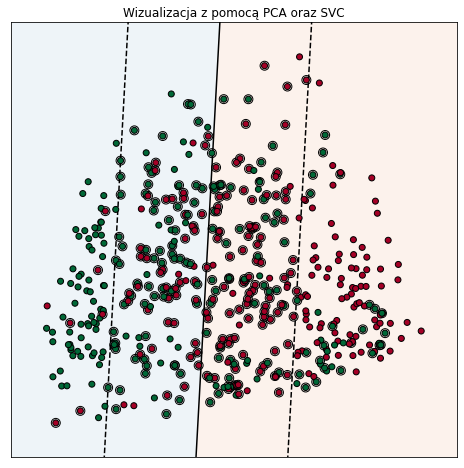

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import svm
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

X, Y = article_vectors, articles["label"]

X = PCA(2).fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

penalty = 5

clf = svm.SVC(kernel="linear", C=penalty)
clf.fit(x_train, y_train)

predicted = clf.predict(x_test)
print(confusion_matrix(y_test,predicted))
print(classification_report(y_test,predicted))
# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]

margin = 1 / np.sqrt(np.sum(clf.coef_**2))
yy_down = yy - np.sqrt(1 + a**2) * margin
yy_up = yy + np.sqrt(1 + a**2) * margin

plt.figure(1, figsize=(8, 8))
plt.clf()
plt.plot(xx, yy, "k-")
plt.plot(xx, yy_down, "k--")
plt.plot(xx, yy_up, "k--")

plt.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=80,
    facecolors="none",
    zorder=10,
    edgecolors="k",
    cmap=cm.get_cmap("RdYlGn"),
)
x_min = X[:, 0].min() - 0.1
x_max = X[:, 0].max() + 0.1
y_min = X[:, 1].min() - 0.1
y_max = X[:, 1].max() + 0.1

plt.scatter(
    X[:, 0], X[:, 1], c=Y, zorder=10, cmap=cm.get_cmap("RdYlGn"), edgecolors="k"
)

plt.axis("tight")

YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)


plt.contourf(XX, YY, Z, cmap=cm.get_cmap("RdBu"), alpha=0.5, linestyles=["-"])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())

plt.title('Wizualizacja z pomocą PCA oraz SVC')
plt.show()


 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 0.4548125846300319


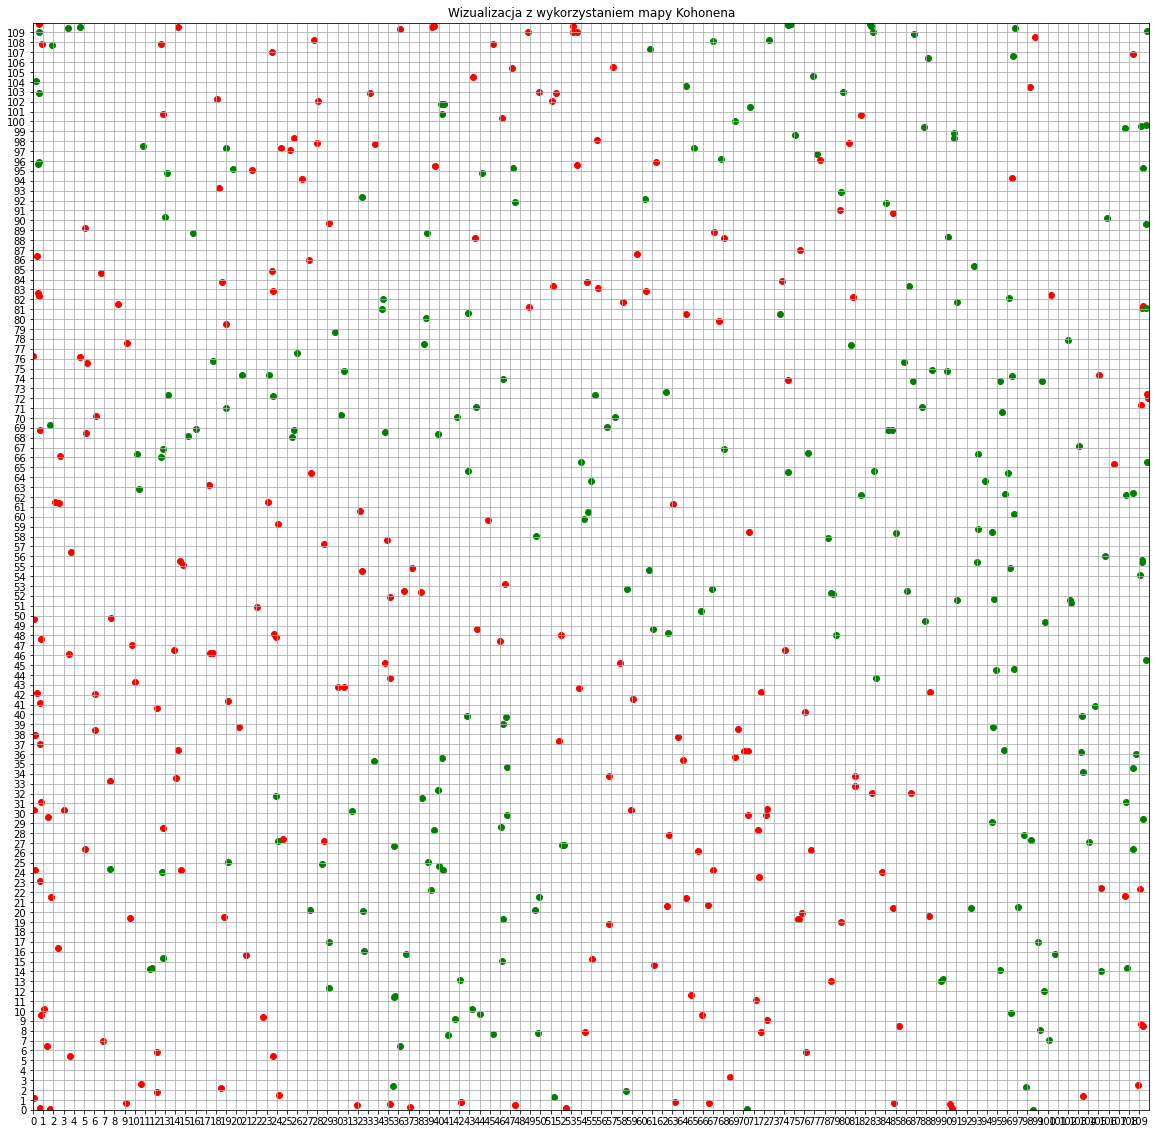

In [23]:
N = int(5*np.sqrt(len(article_vectors)))
som = MiniSom(N,N,len(key_words),sigma=8, learning_rate=0.25, activation_distance='cosine')

som.random_weights_init(article_vectors)
som.train_random(article_vectors,2000,verbose=True)

x = plt.figure(figsize=(20, 20))

for _, (c, vec) in enumerate(zip(['r' if label==0 else 'g' for label in articles["label"]], article_vectors)):
    winnin_position = som.winner(vec)
    plt.scatter(winnin_position[0]+np.random.rand()*.9, winnin_position[1]+np.random.rand()*.9,color=c)
plt.xticks(range(N))
plt.yticks(range(N))
plt.grid()
plt.title("Wizualizacja z wykorzystaniem mapy Kohonena")
plt.xlim([0, N])
plt.ylim([0, N])
plt.plot()
plt.show()
plt.close(x)

### Simulation

In [24]:
key_words = [s for _,s in key_pro_words + key_anti_words]
close_words = find_close_words(words_pa,key_words)
pro_words_pa = [words for i,words in enumerate(words_pa) if articles["label"][i]==1]
anti_words_pa = [words for i,words in enumerate(words_pa) if articles["label"][i]==0]
vector_colors = ['r' if i>len(key_pro_words) else 'g' for i,_ in enumerate(key_words)]

sigma = 8
learning_rate = 0.5
size = int(5*np.sqrt(len(key_words)))

anti_knowledge_data,_ = random_percent(anti_words_pa,0.8)
pro_knowledge_data,_ = random_percent(pro_words_pa,0.8)
all_knowledge_data_1, anti_read_data = random_percent(anti_words_pa,0.5*0.8)
all_knowledge_data_2, pro_read_data = random_percent(pro_words_pa,0.5*0.8)

all_knowledge_data = all_knowledge_data_1 + all_knowledge_data_2

In [25]:
def read_data(who: MiniSom, what: list, learning_rate, title=''):
    fig, plots = plt.subplots(1, 1,figsize=(20,20))
    new = MiniSom(*who.get_weights().shape,sigma=16,learning_rate=learning_rate,activation_distance='cosine')
    new._weights = deepcopy(who.get_weights())

    new.train(what,200,verbose=True)

    plot_vectors(plots,new,what,vector_colors,key_words,who.get_weights().shape[0],title)

    plt.show()
    plt.close(fig)

In [26]:
from preprocessing.vectors import tfidf_vectors

def new_simulation(who,what,title):
    vectors = tfidf_vectors(what)
    for n in [1,0.5,0.25,0.15,0.1,0.05,0.01]:
        read_data(who,vectors,n,
                  title=f'{title} dla learning rate = {n}')

def knowledge_init(som,knowledge,title=''):
    fig, plot = plt.subplots(1, 1,figsize=(20,20))
    vectors = tfidf_vectors(knowledge)
    som.train(vectors,300,verbose=True)

    plot_vectors(plot,som,vectors,vector_colors,key_words,som.get_weights().shape[0],title)

    plt.show()
    plt.close(fig)

In [27]:
anti_person = MiniSom(size,size,len(close_words),sigma=sigma,learning_rate=learning_rate, activation_distance='cosine')
pro_person = MiniSom(size,size,len(close_words),sigma=sigma,learning_rate=learning_rate, activation_distance='cosine')
all_person = MiniSom(size,size,len(close_words),sigma=sigma,learning_rate=learning_rate, activation_distance='cosine')

 [ 300 / 300 ] 100% - 0:00:00 left 
 quantization error: 0.7062989987509856


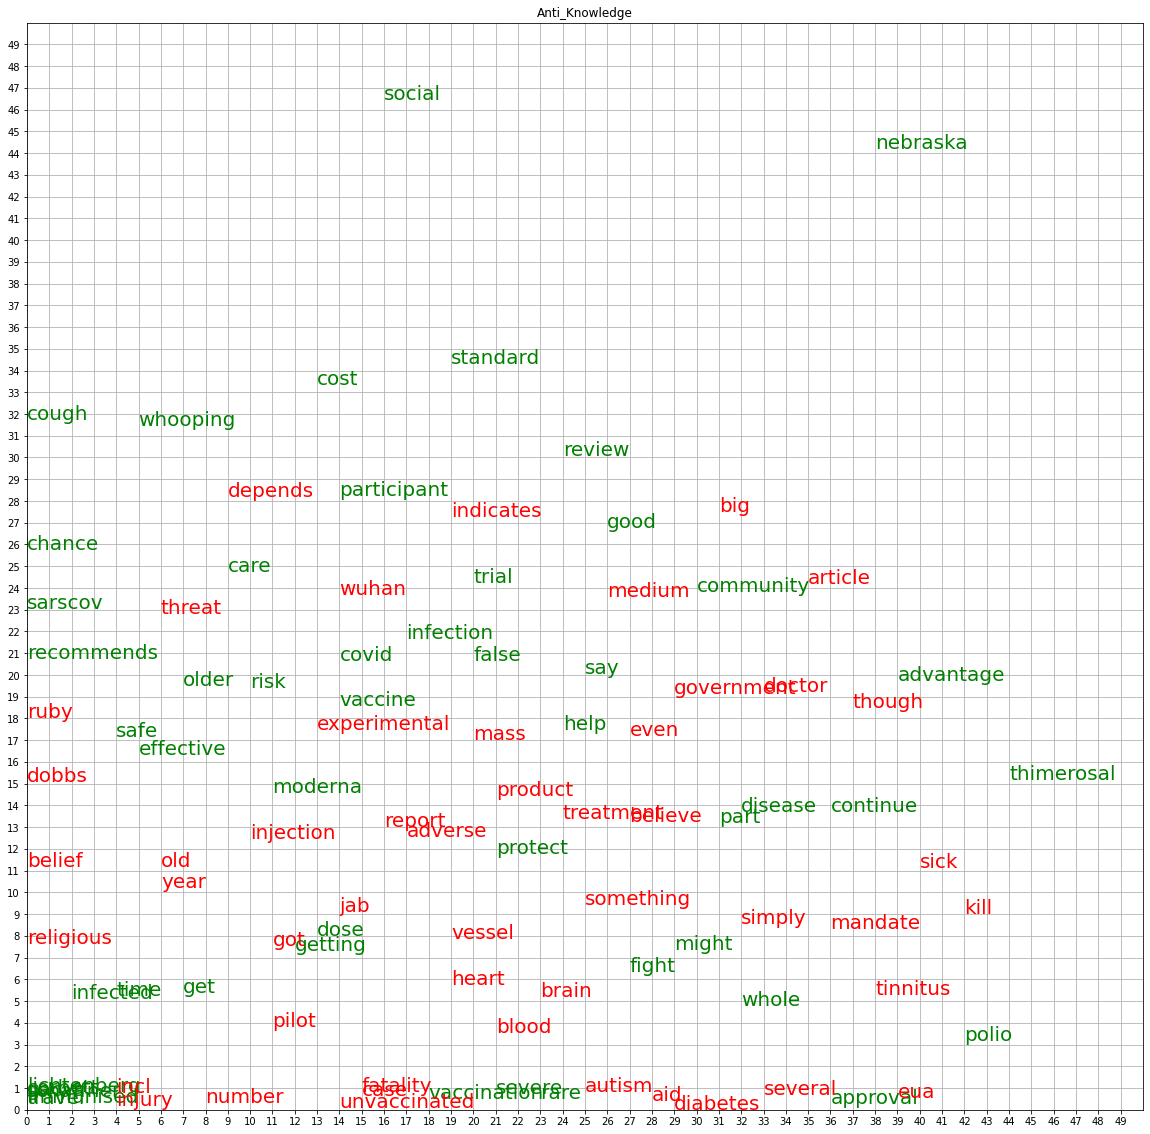

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.805984853038562


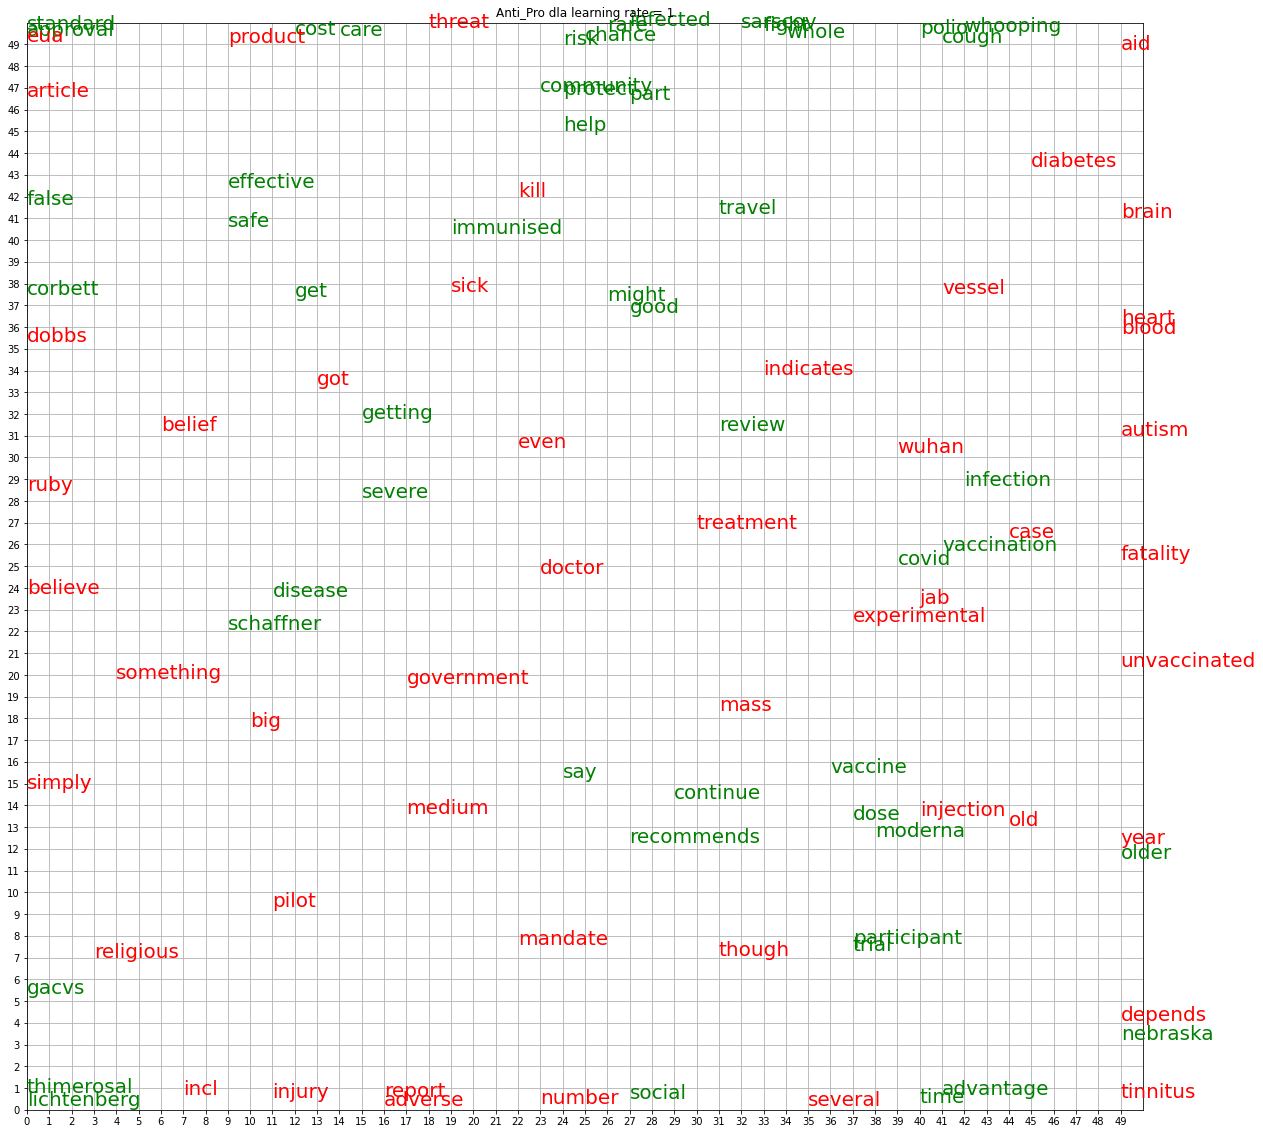

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8295800056467726


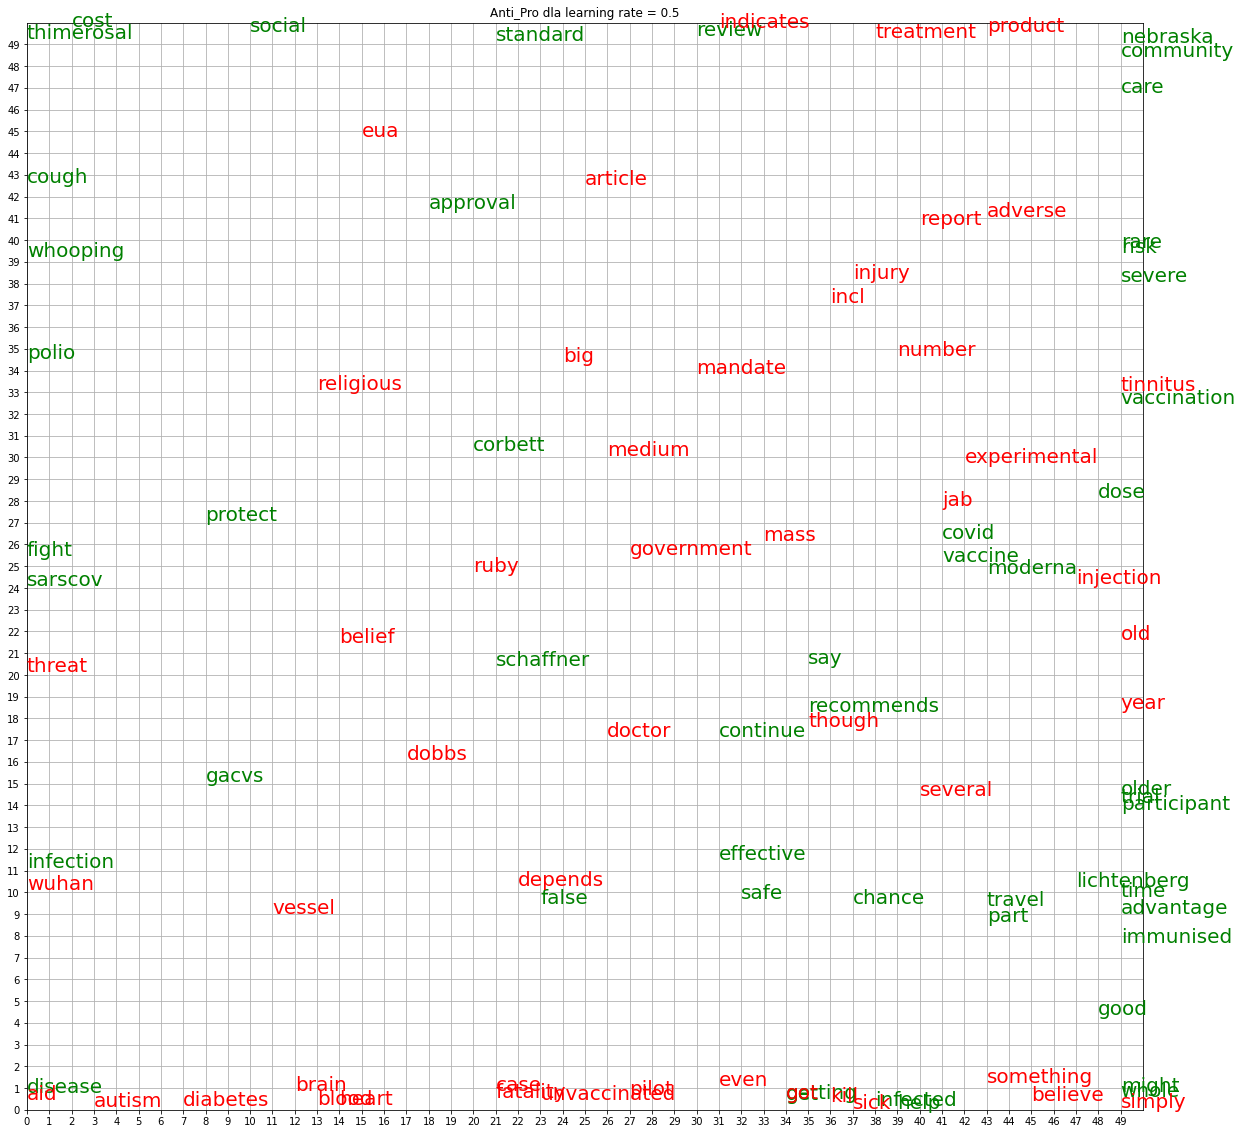

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8646945550688732


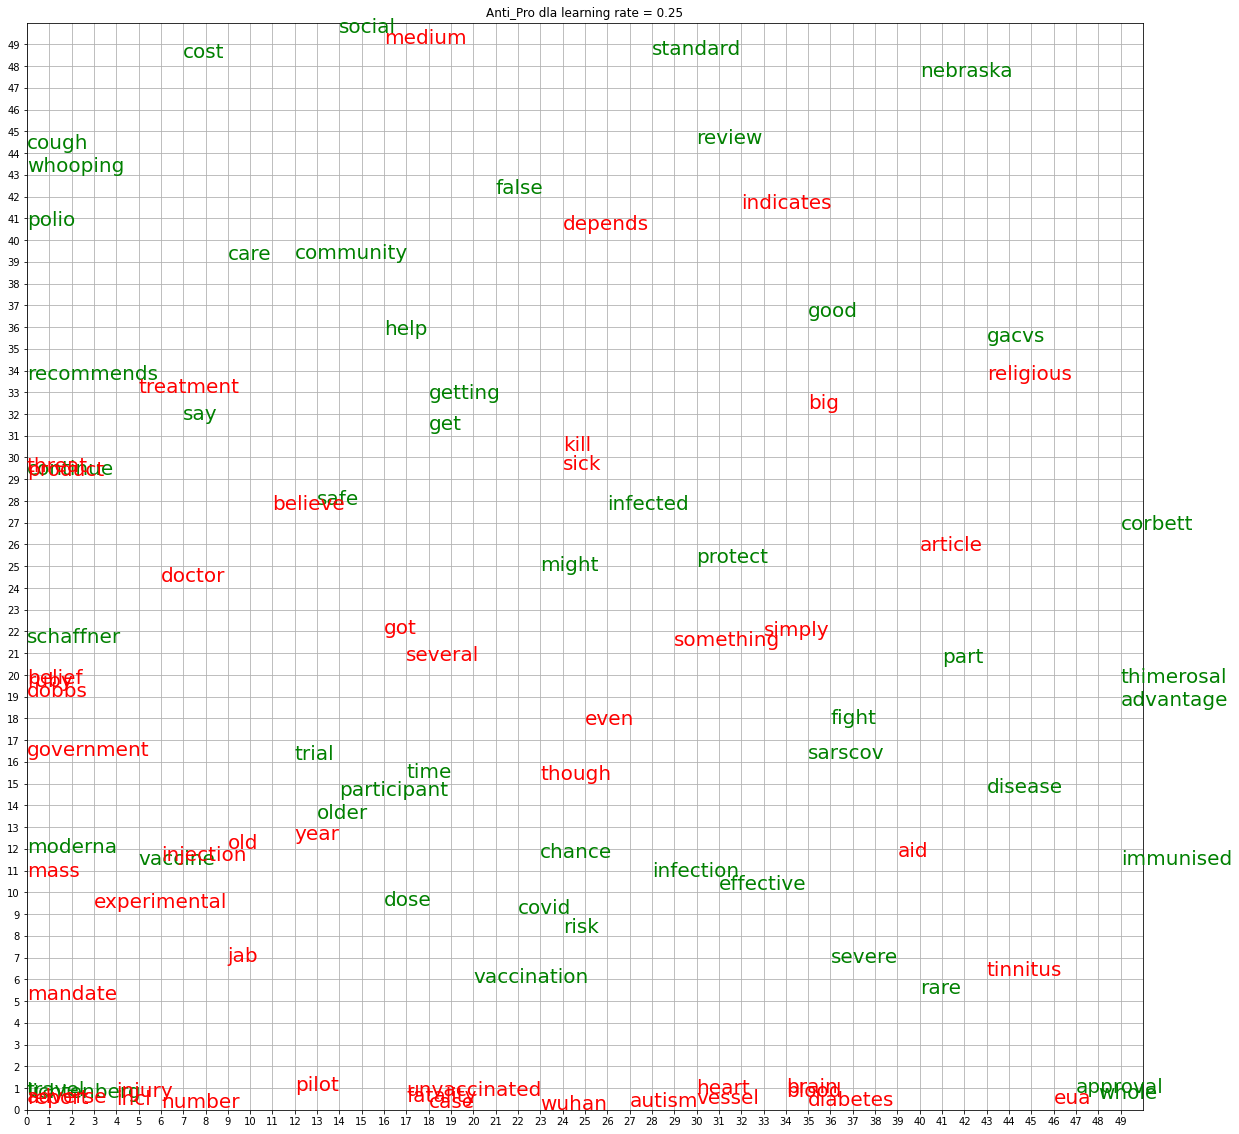

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8867828616668995


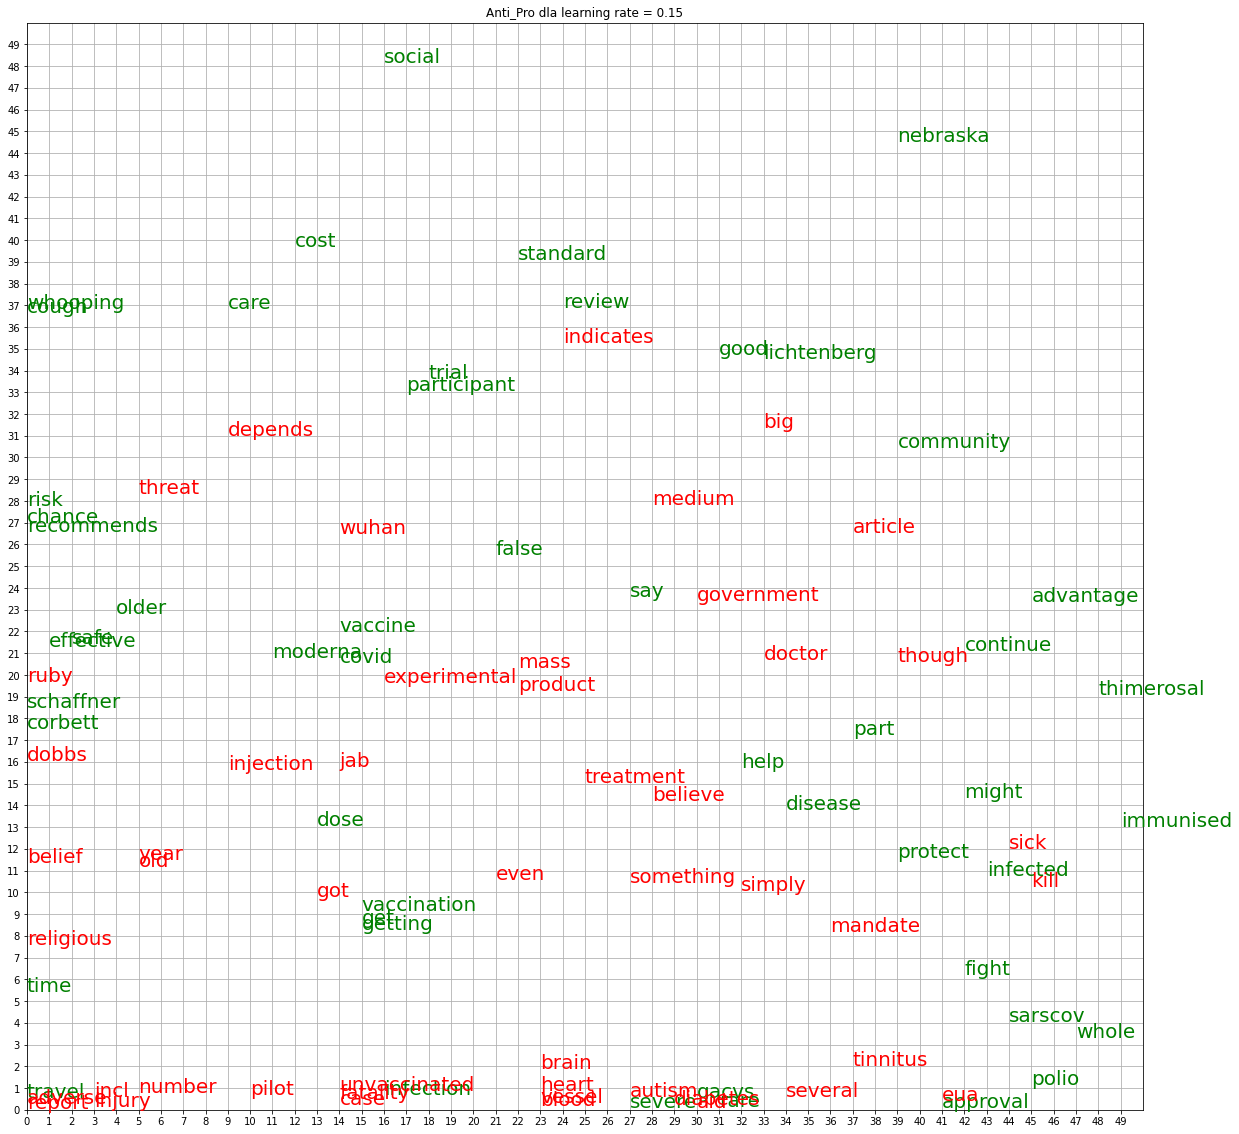

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8944327516215528


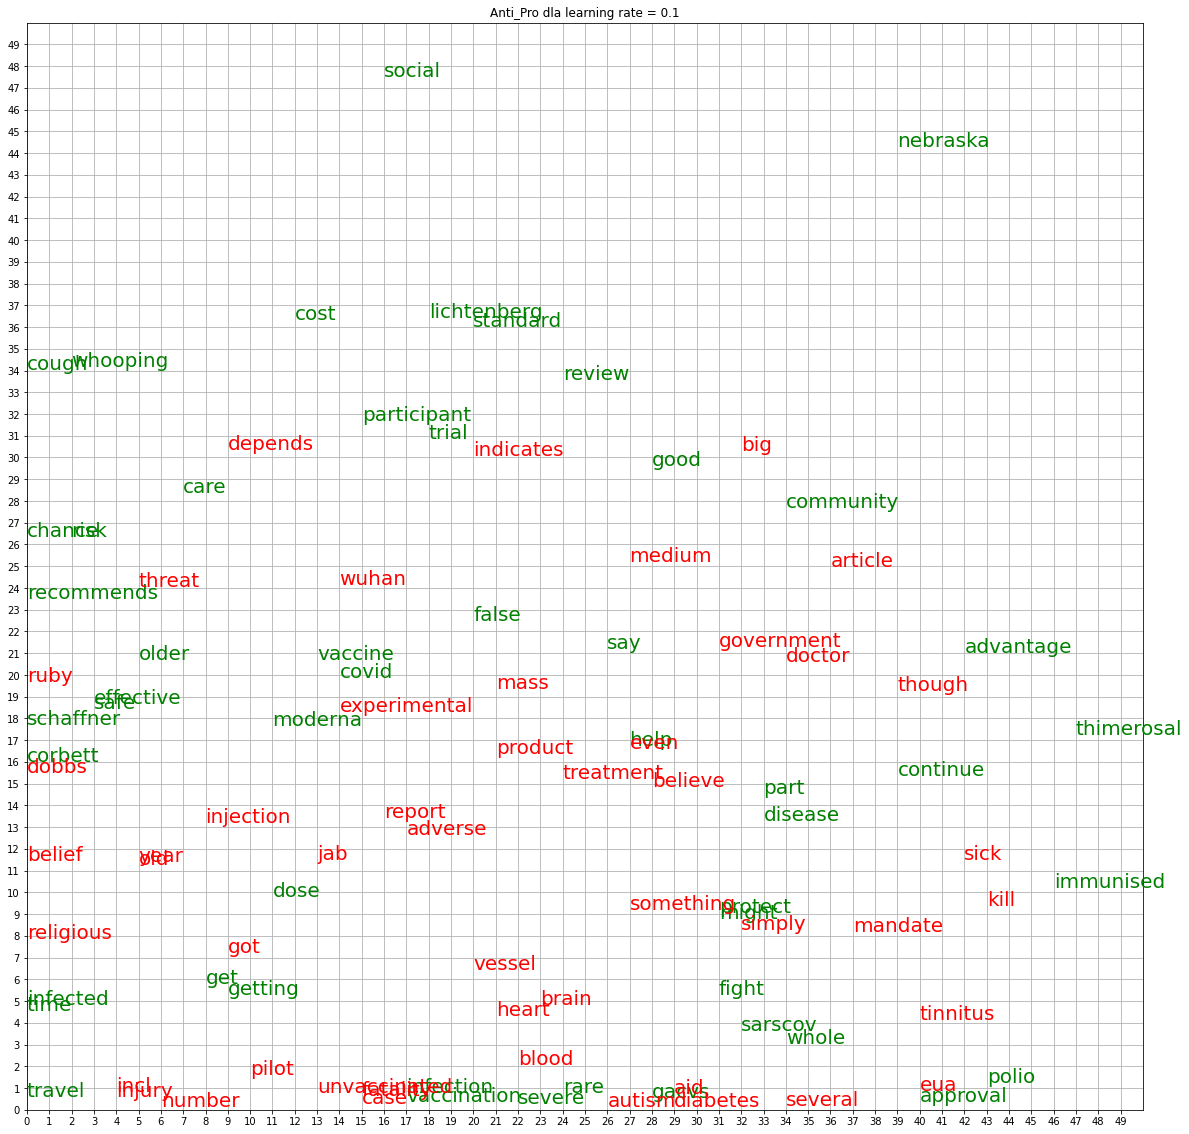

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8815242958322186


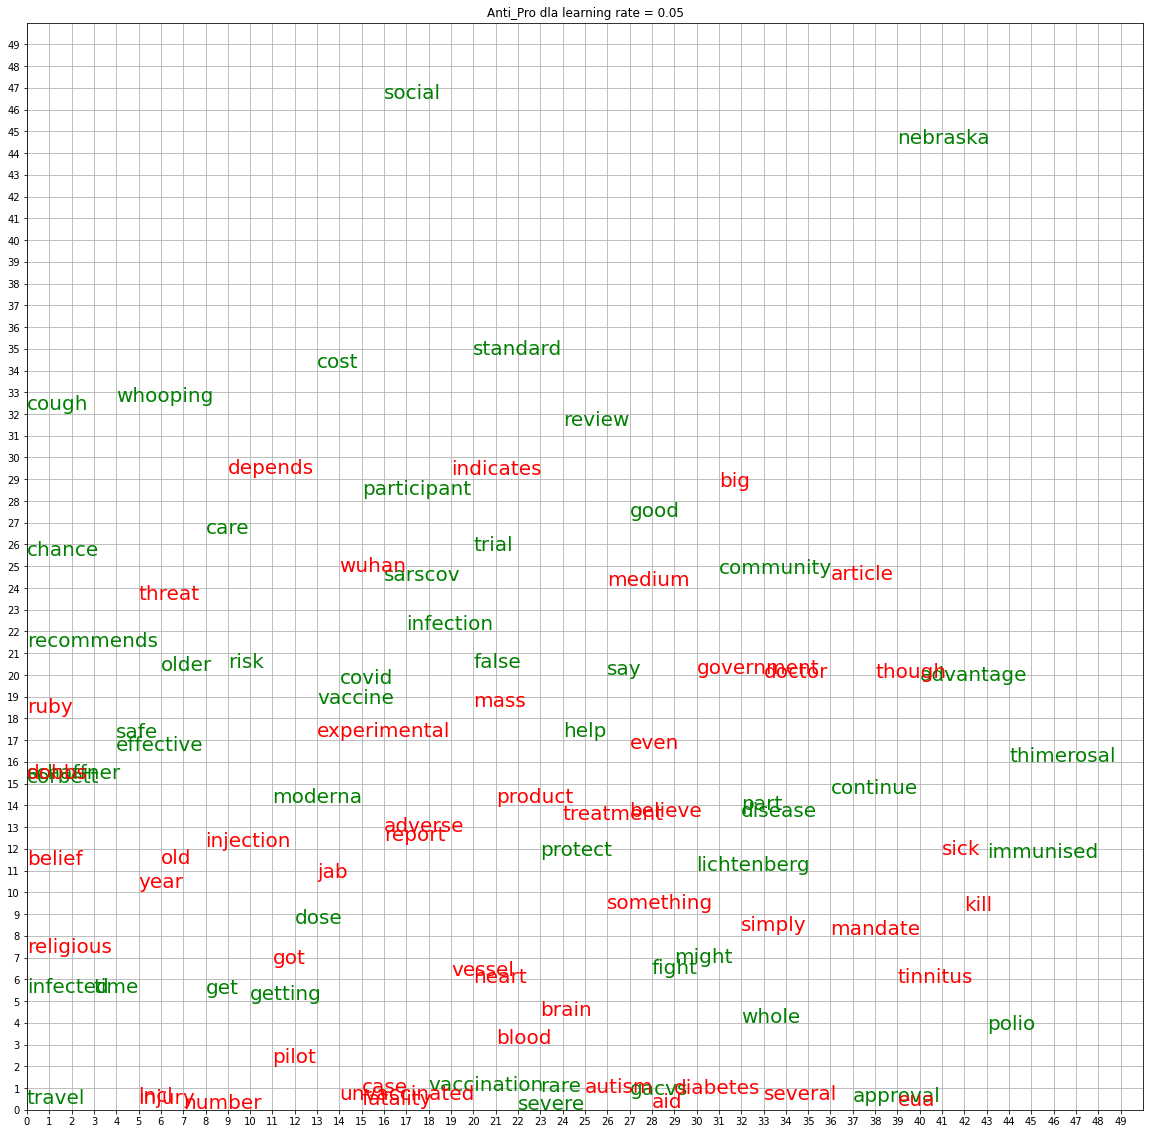

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8326620832796042


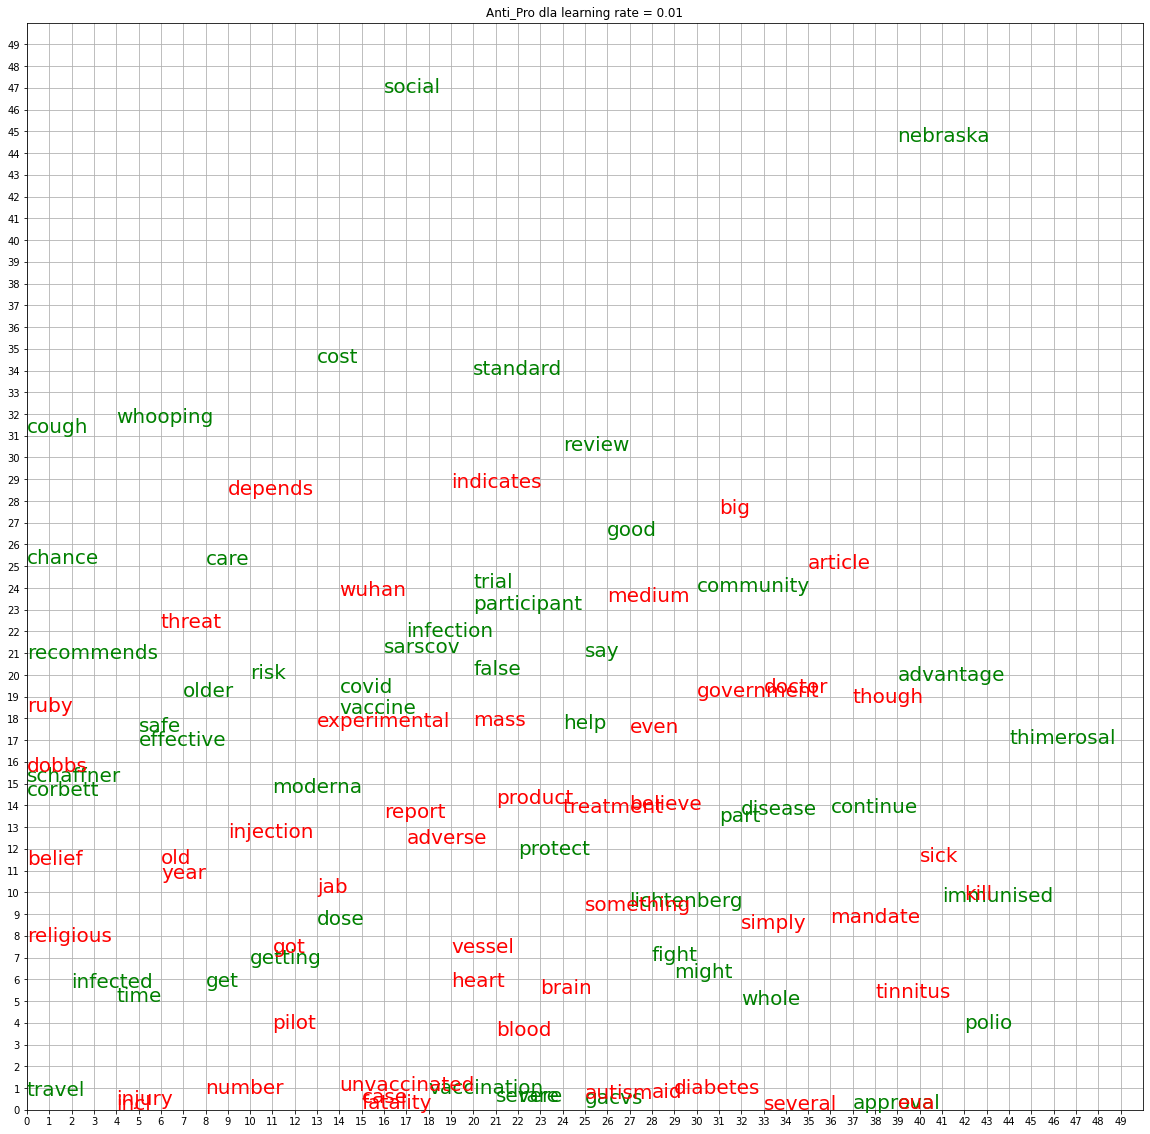

In [28]:
knowledge_init(anti_person,anti_words_pa,"Anti_Knowledge")
to_read,_ = random_percent(pro_words_pa,0.8)
new_simulation(anti_person,anti_words_pa+to_read,"Anti_Pro")

 [ 300 / 300 ] 100% - 0:00:00 left 
 quantization error: 0.7066029370354072


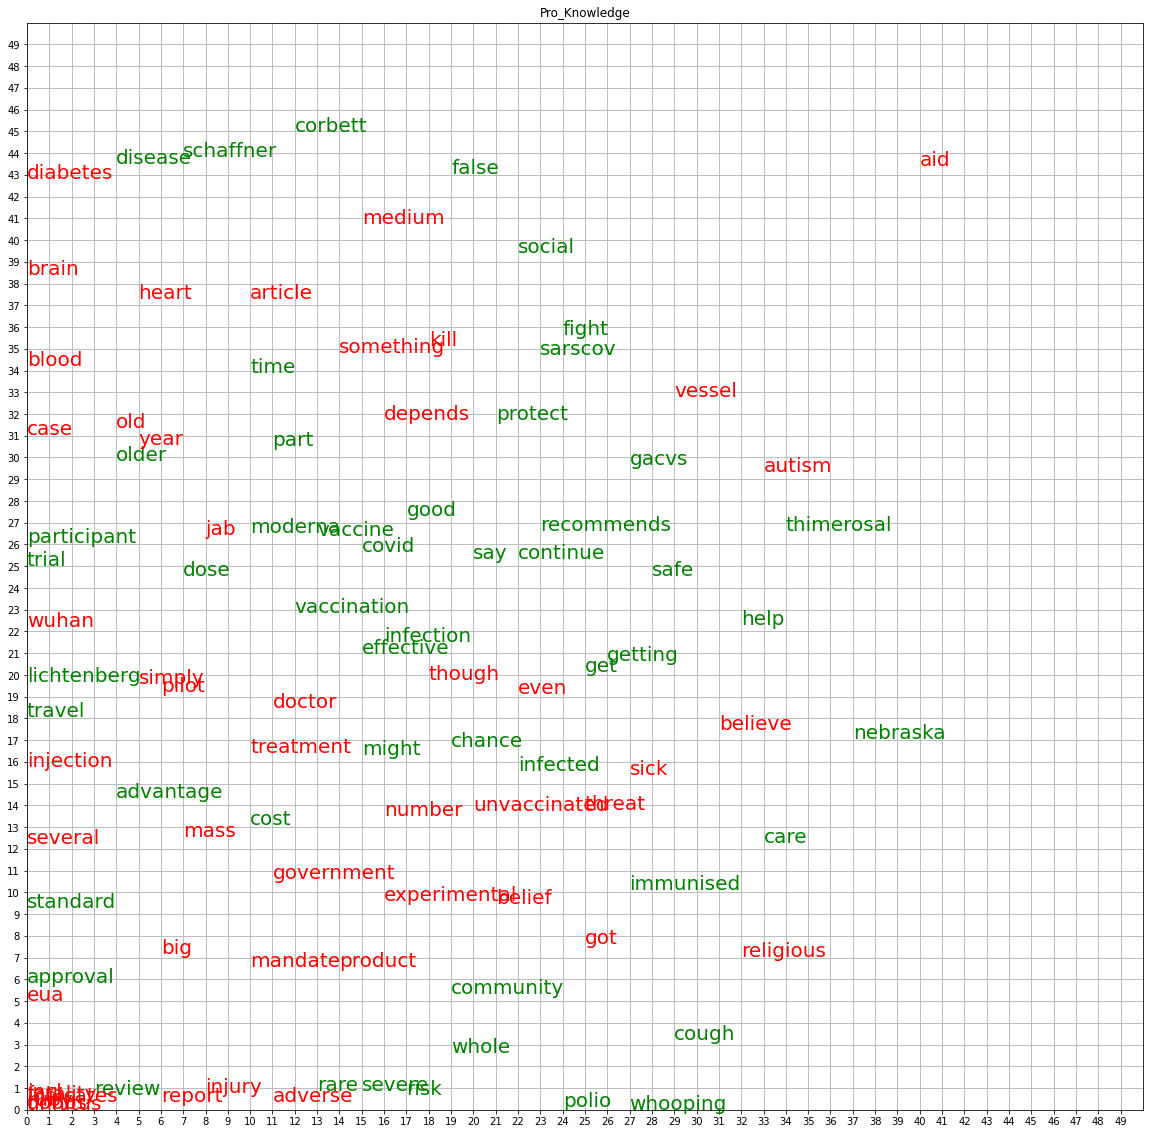

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8058478659174313


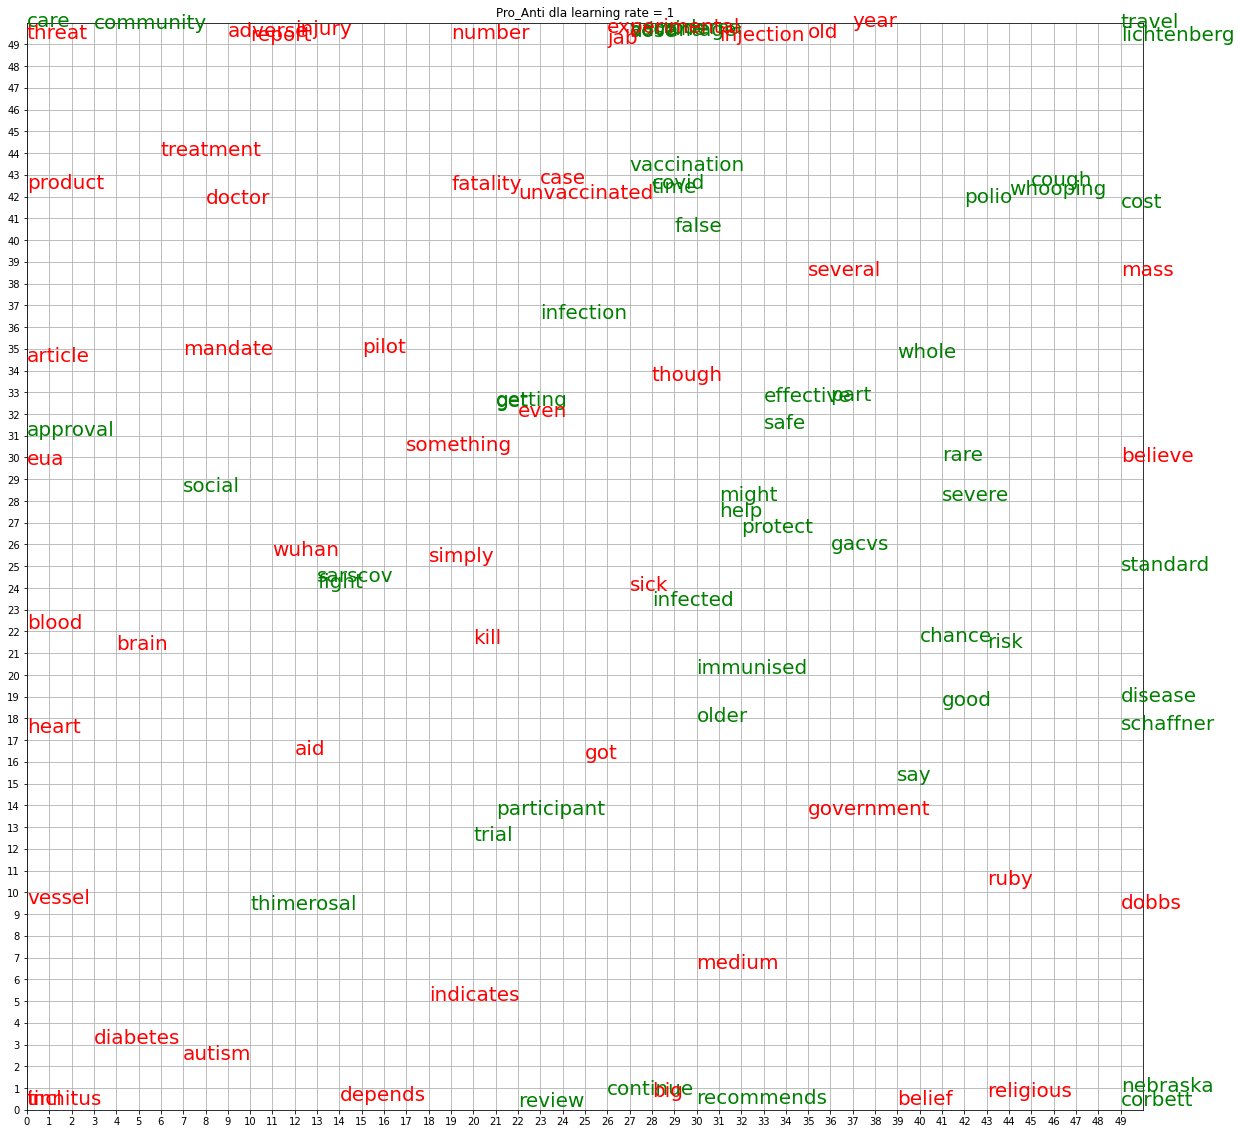

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8257045763983535


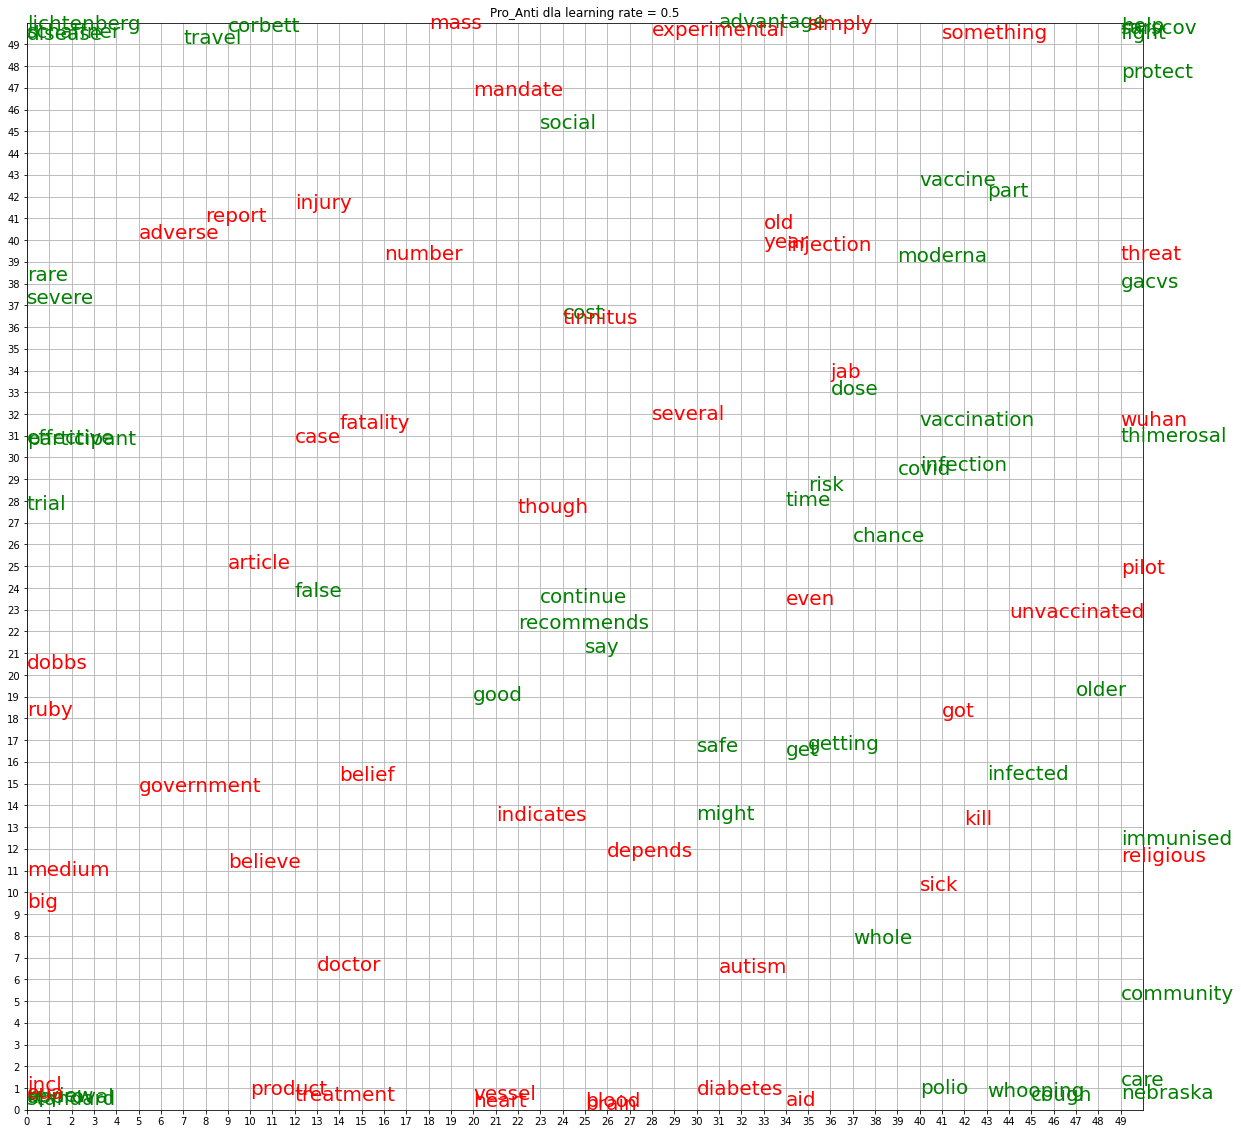

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8601894157176925


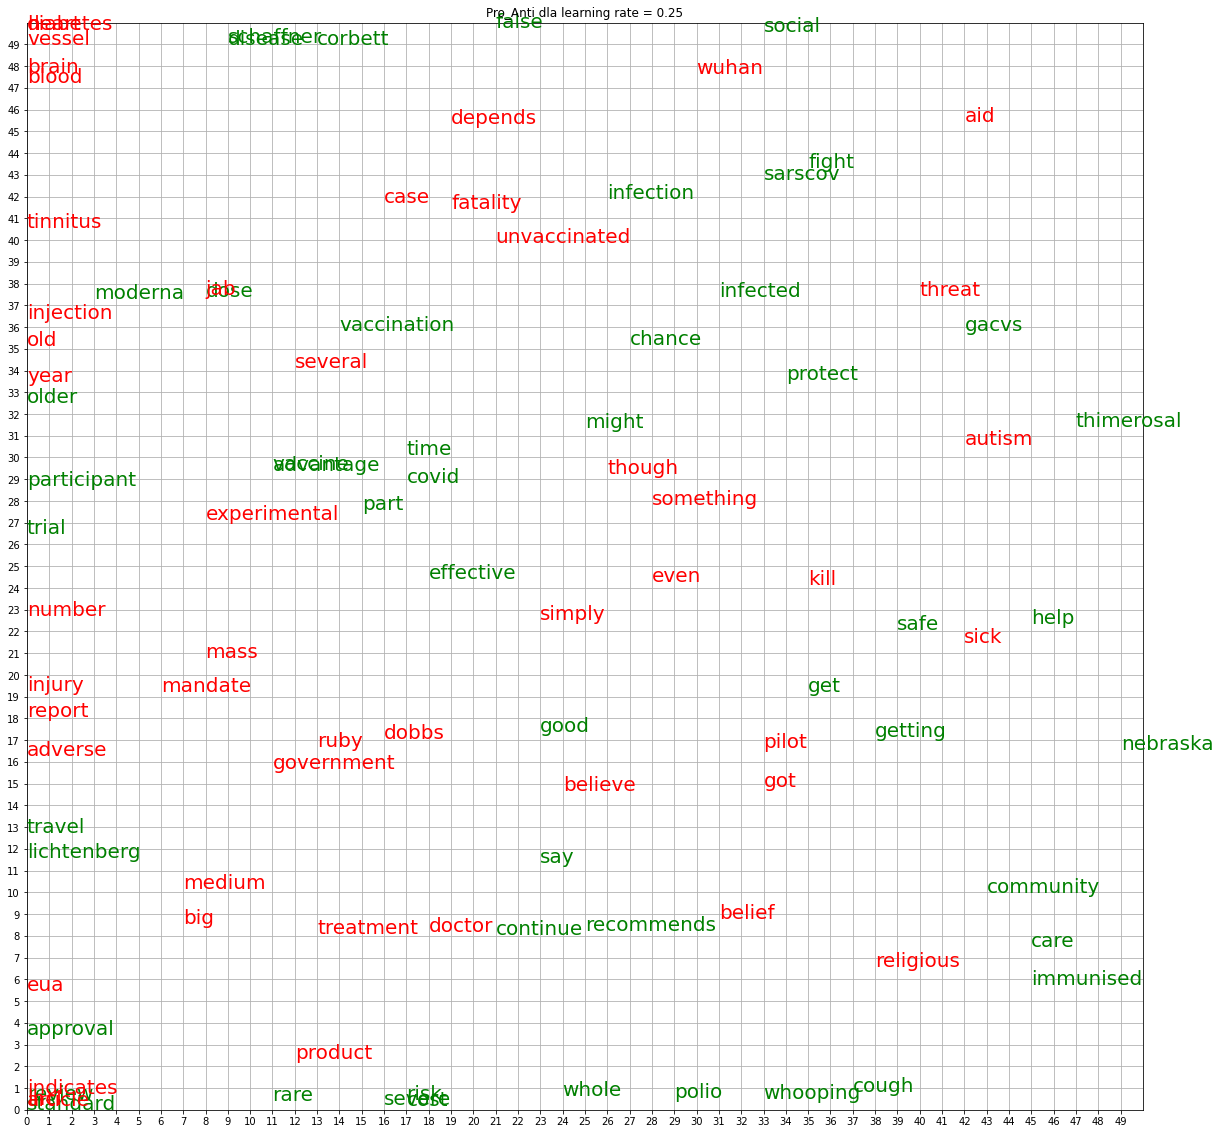

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8826419085709795


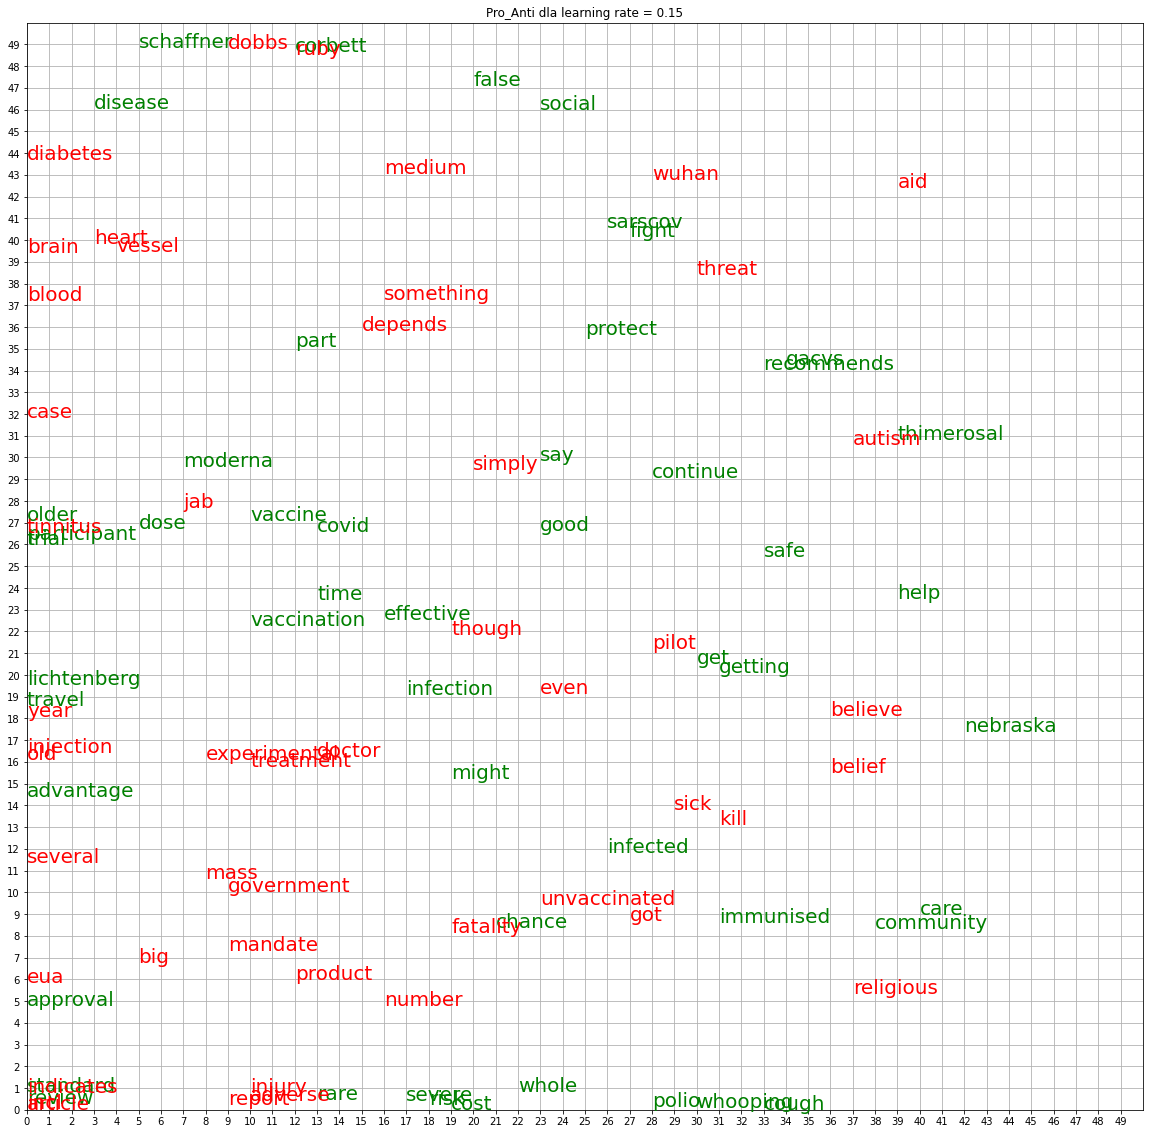

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.888008250753648


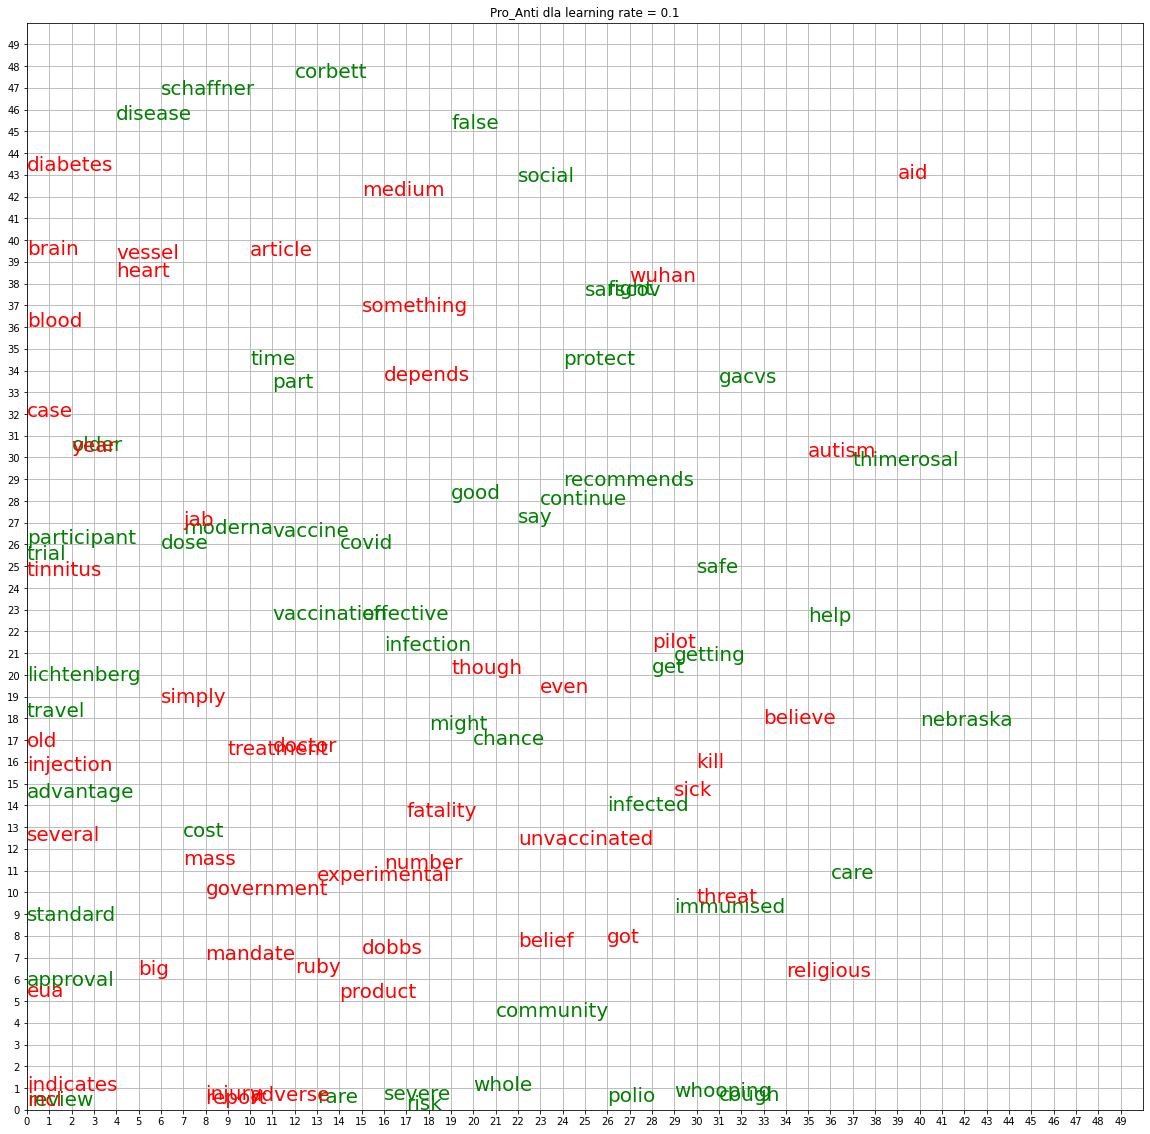

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8729529063315907


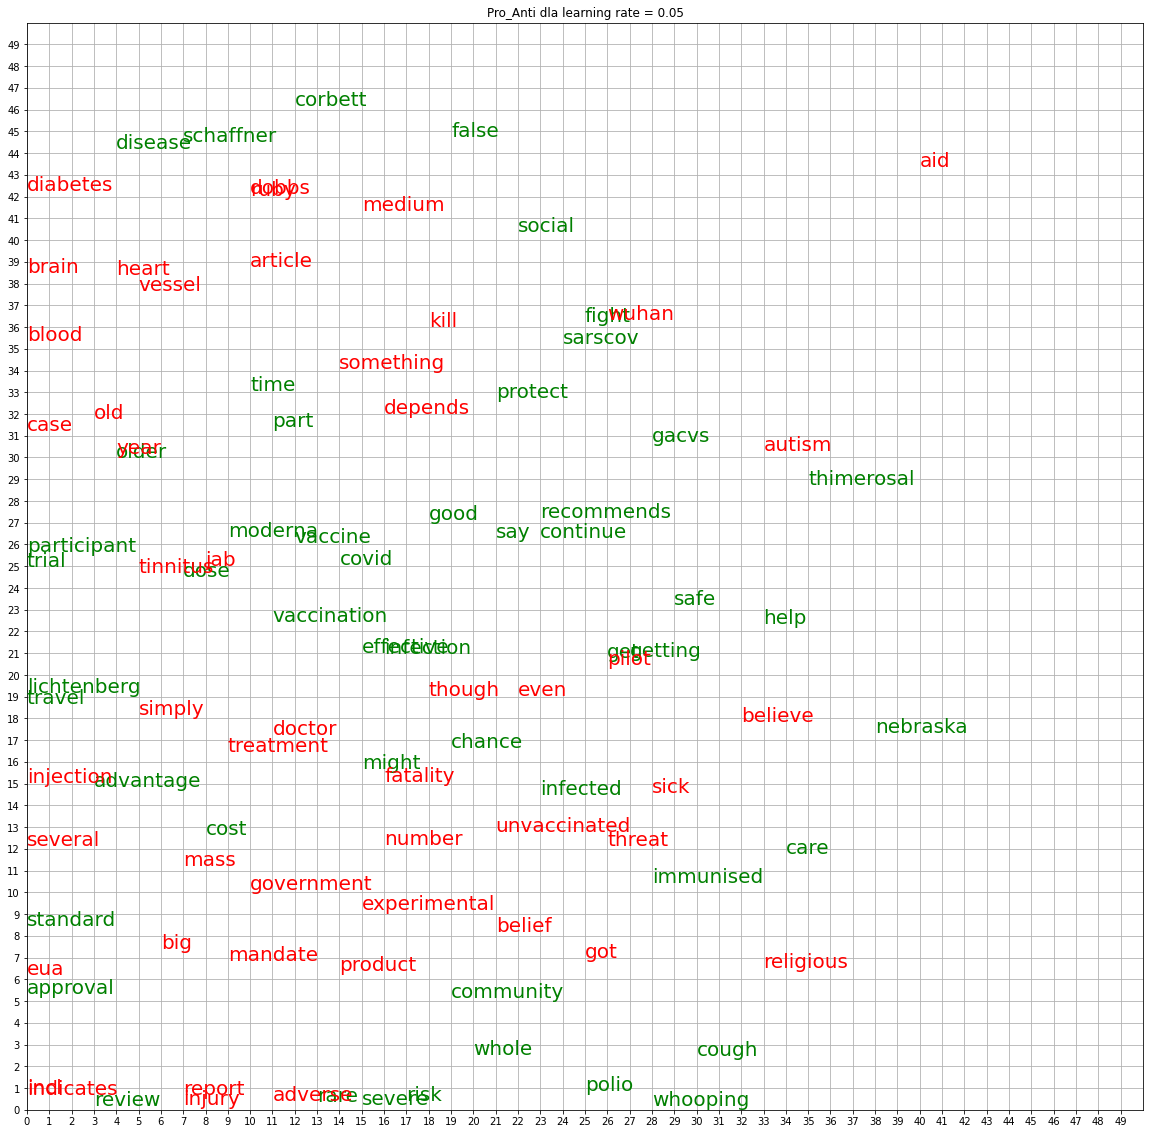

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8274052280860192


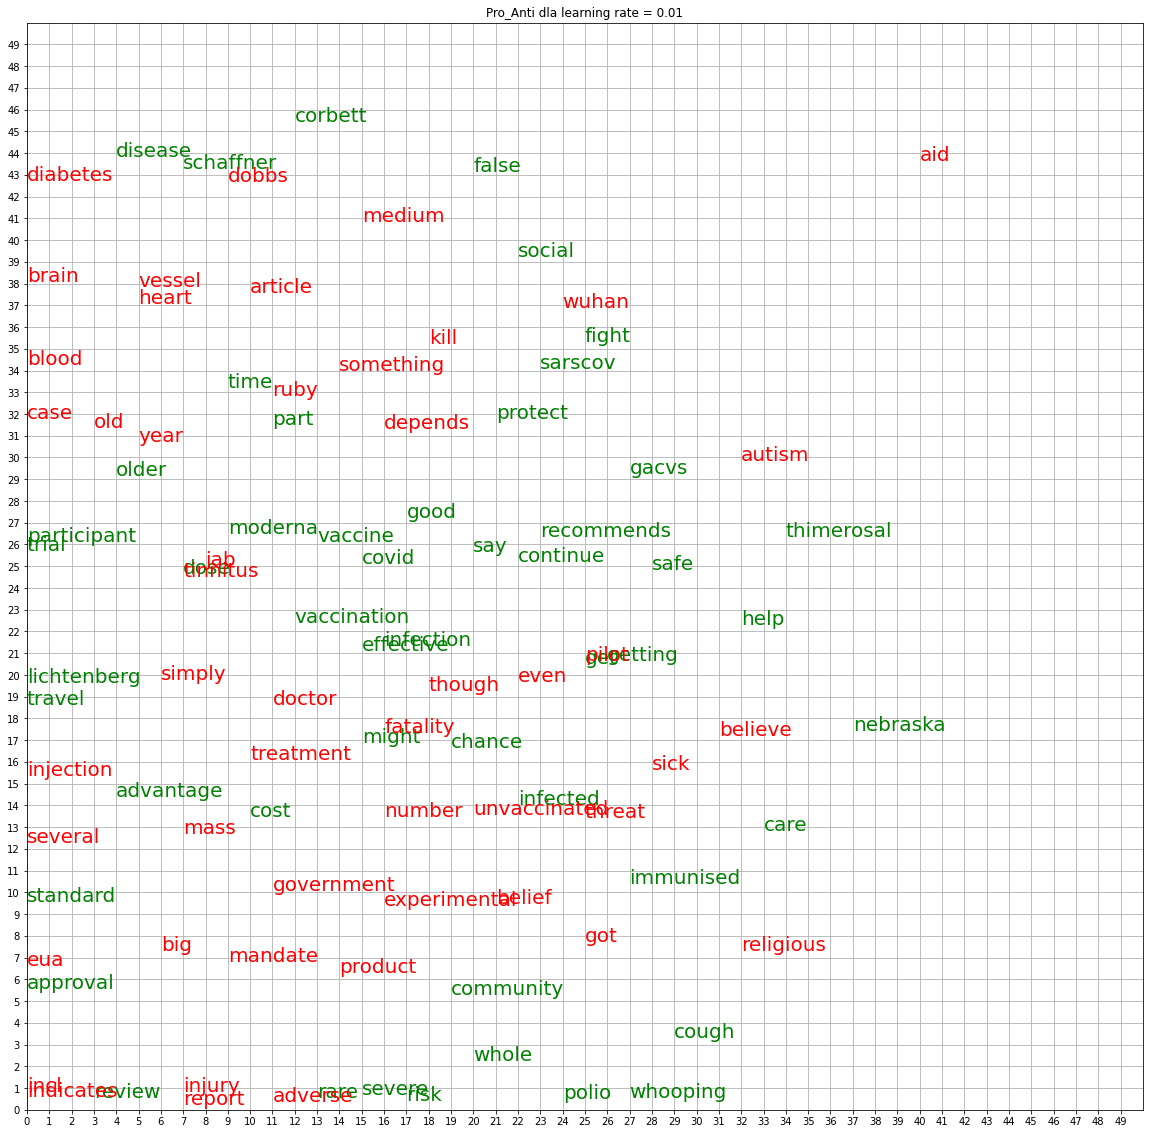

In [29]:
knowledge_init(pro_person,pro_words_pa,"Pro_Knowledge")
to_read,_ = random_percent(anti_words_pa,0.8)
new_simulation(pro_person,pro_words_pa+to_read,"Pro_Anti")

 [ 300 / 300 ] 100% - 0:00:00 left 
 quantization error: 0.7077784400925269


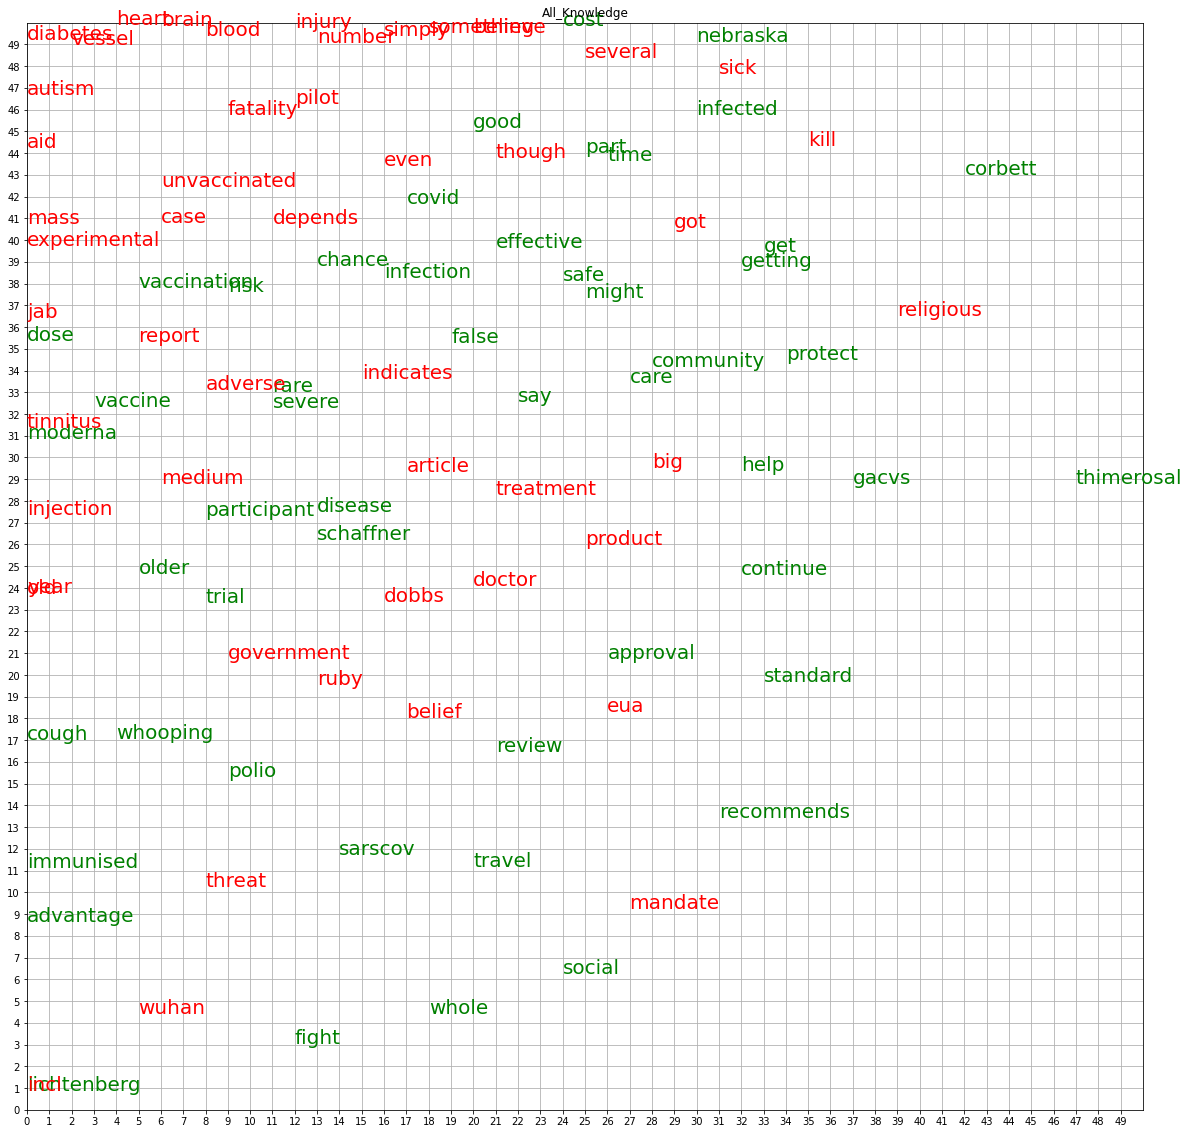

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8144995410920771


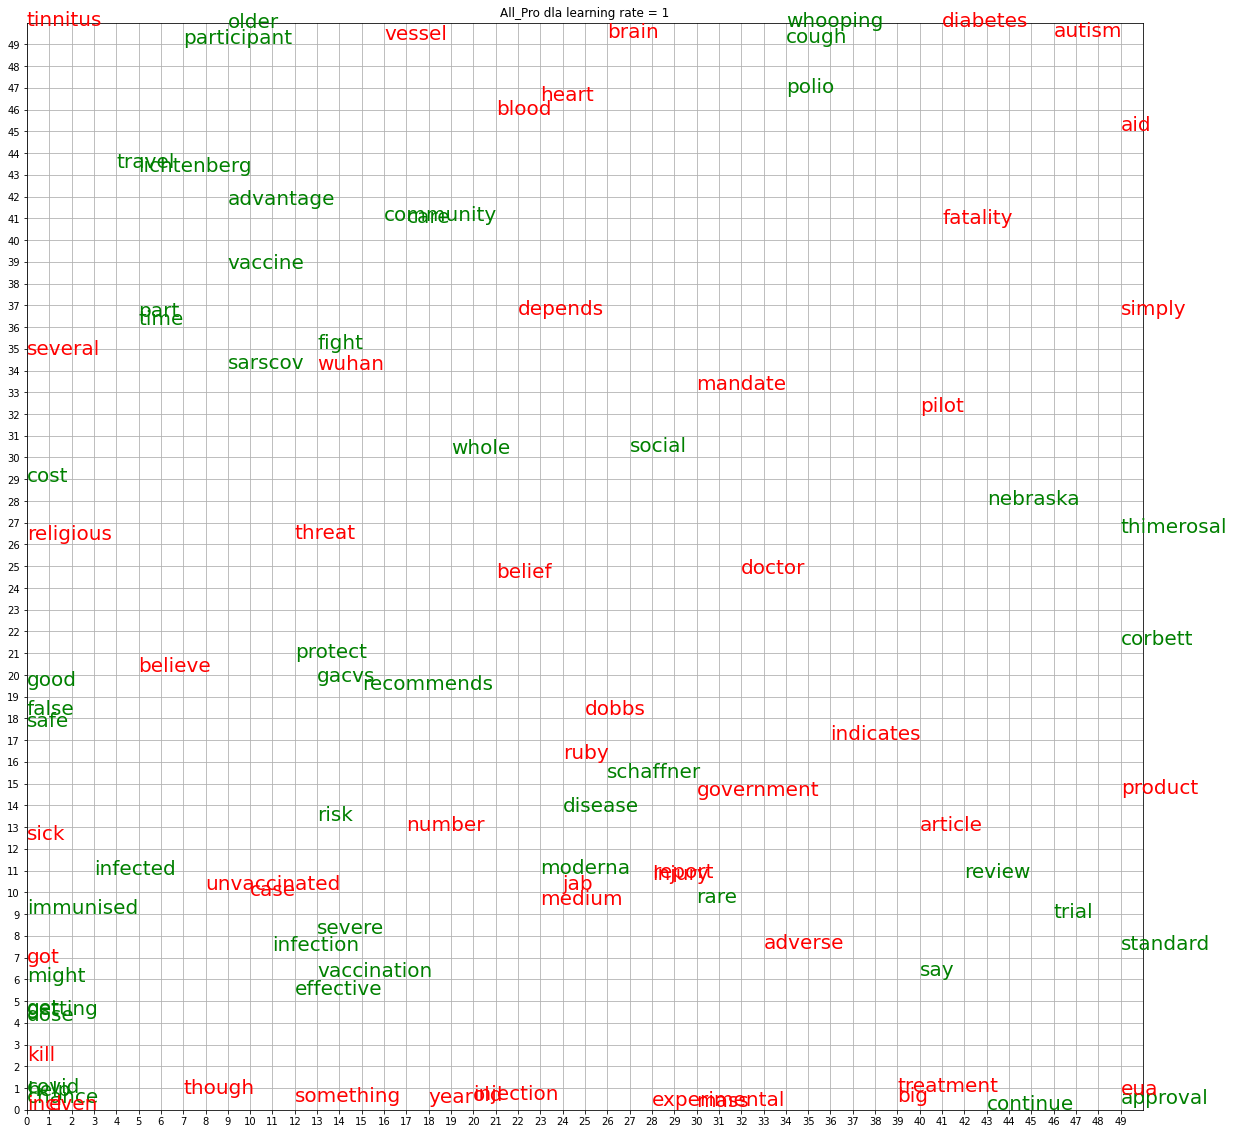

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8319272146636935


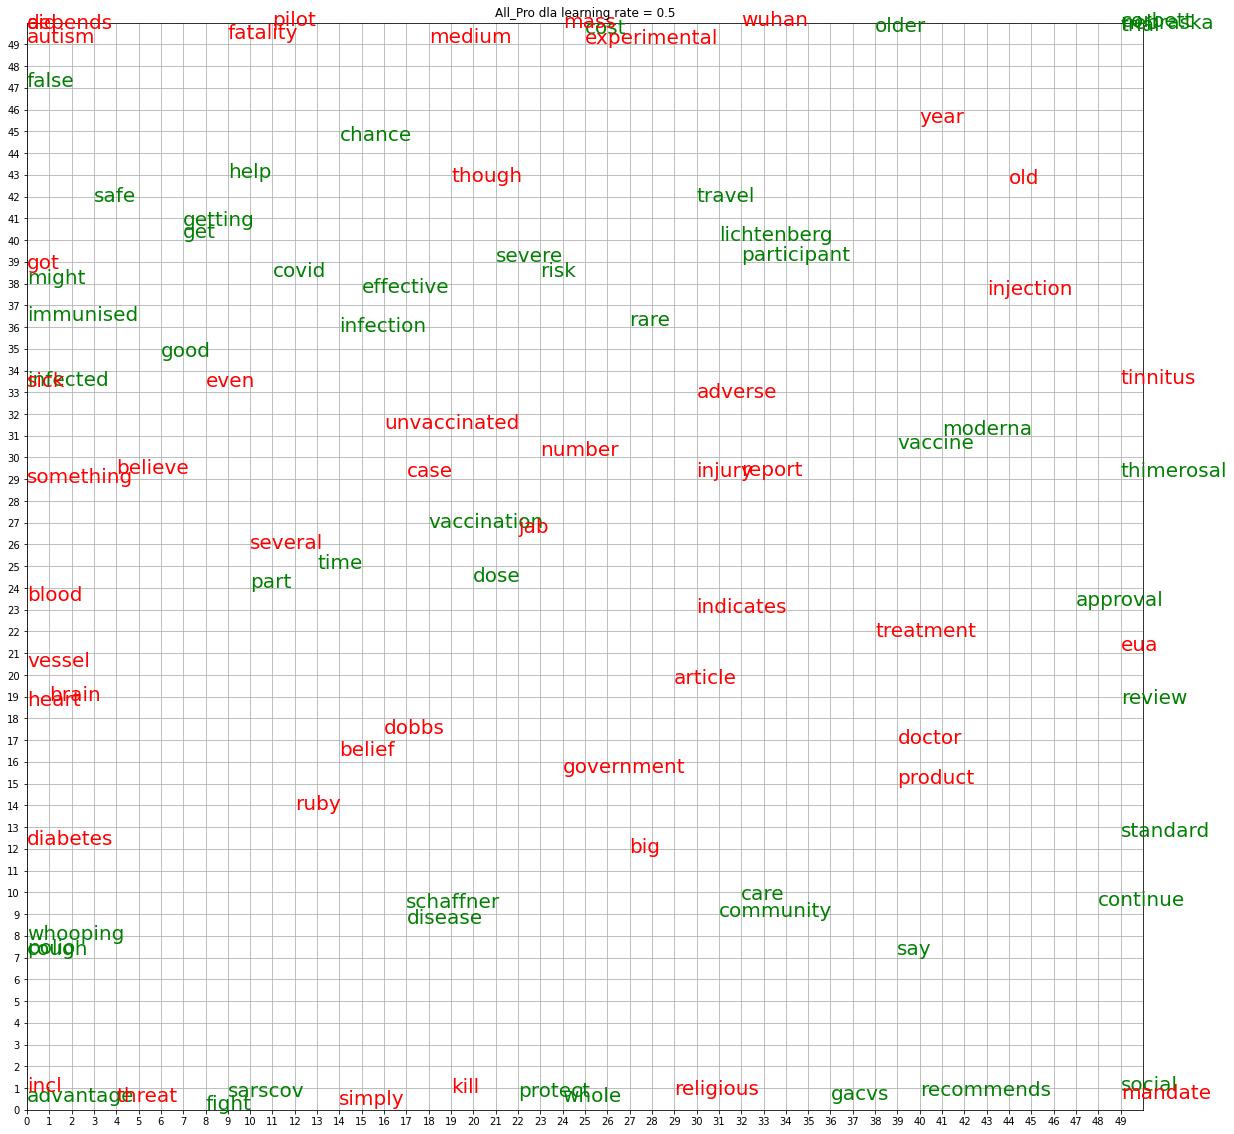

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8631159314477838


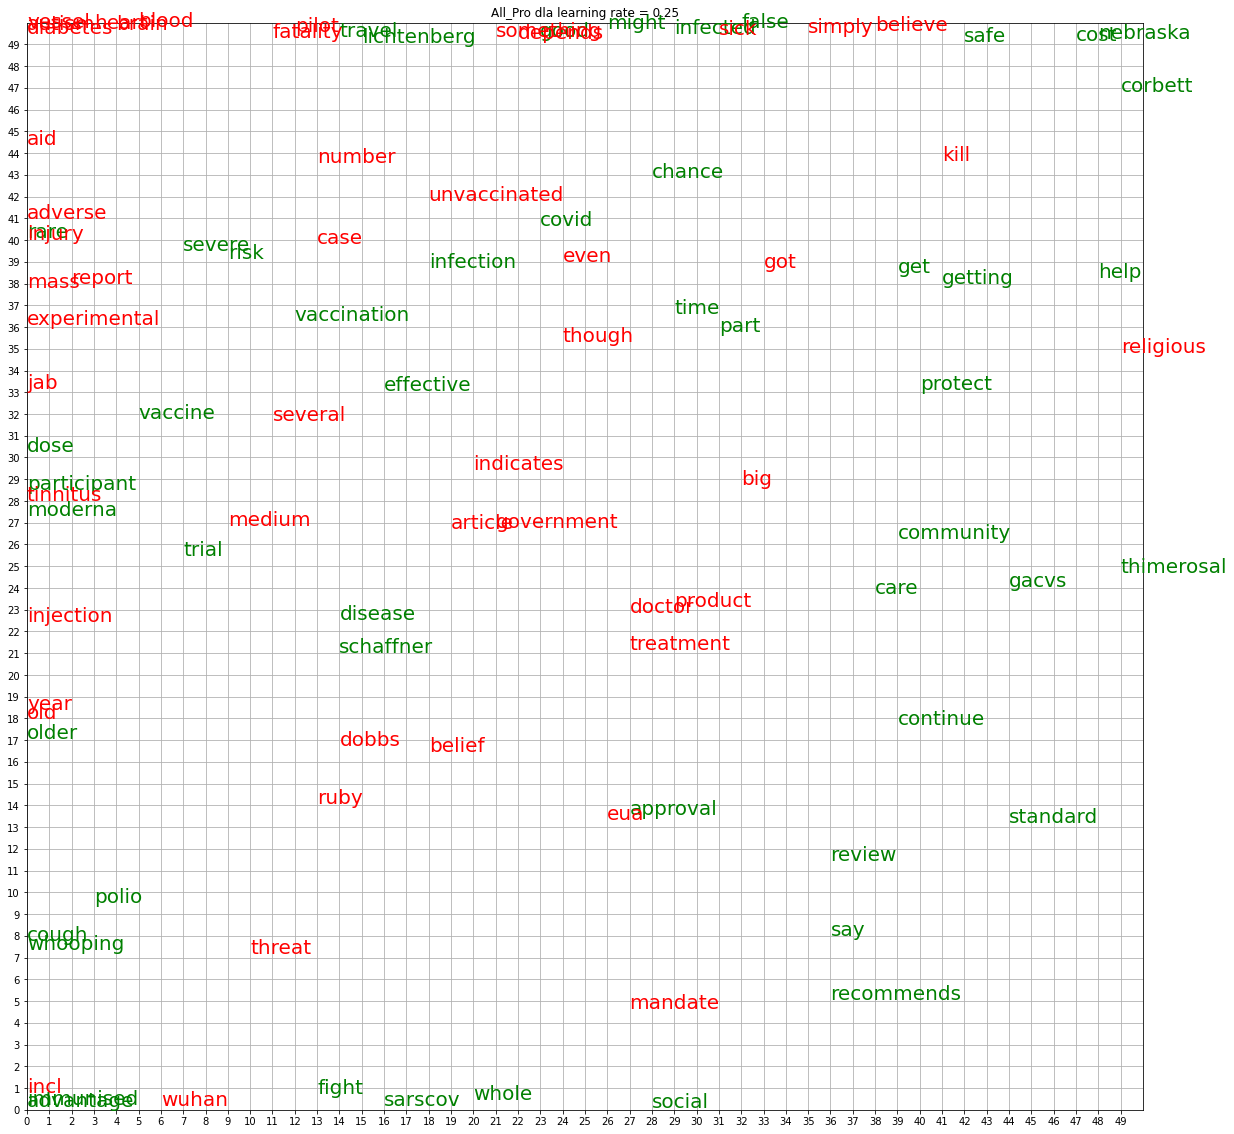

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8786076493915627


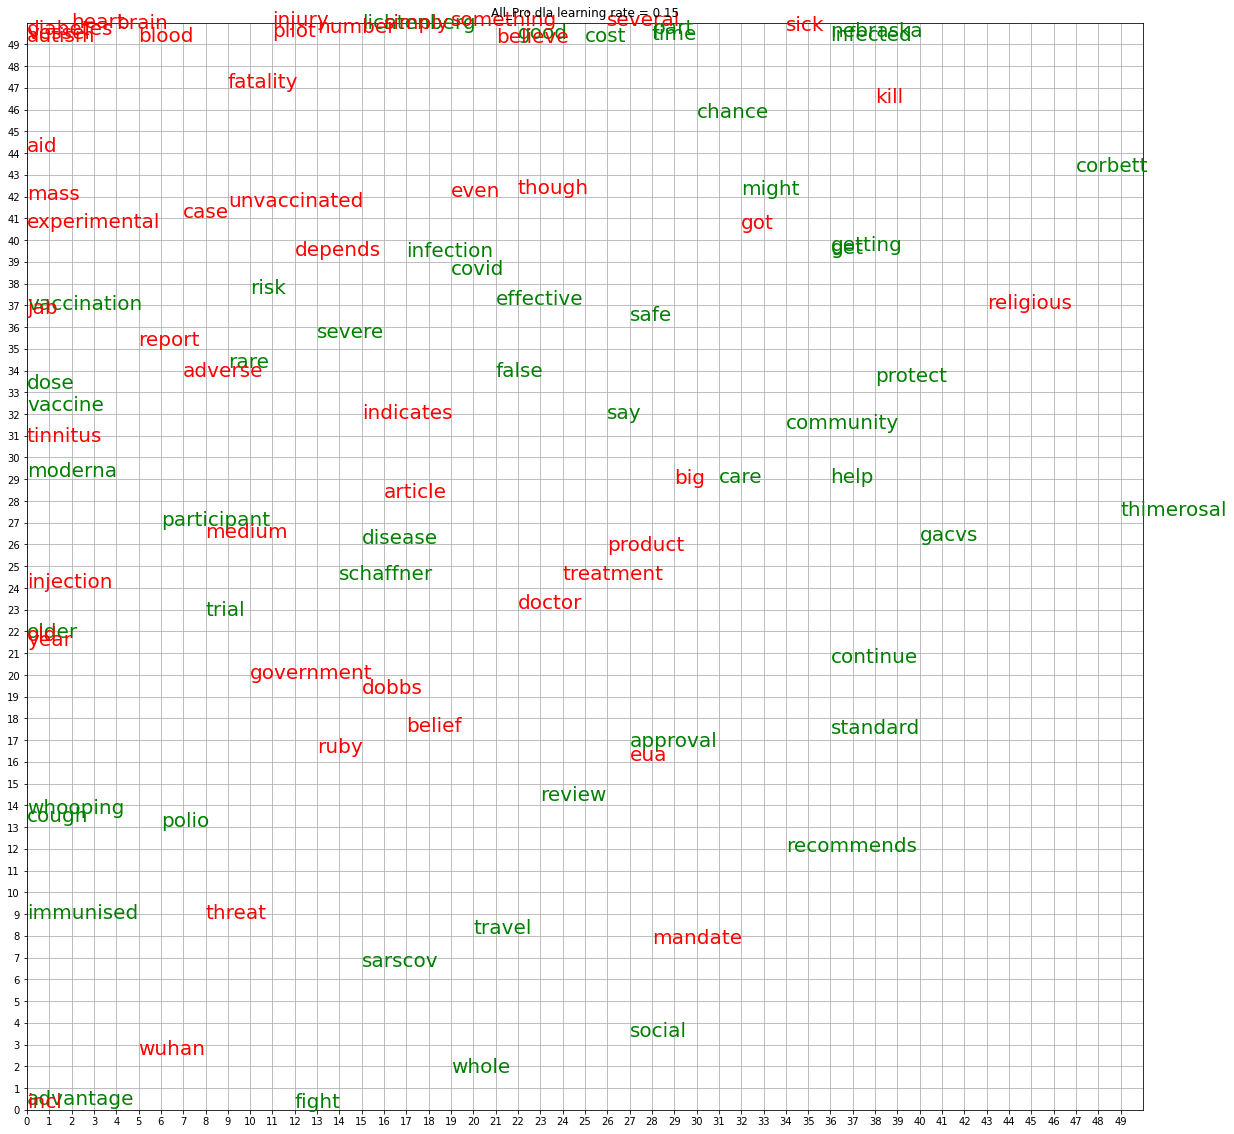

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8767807444447862


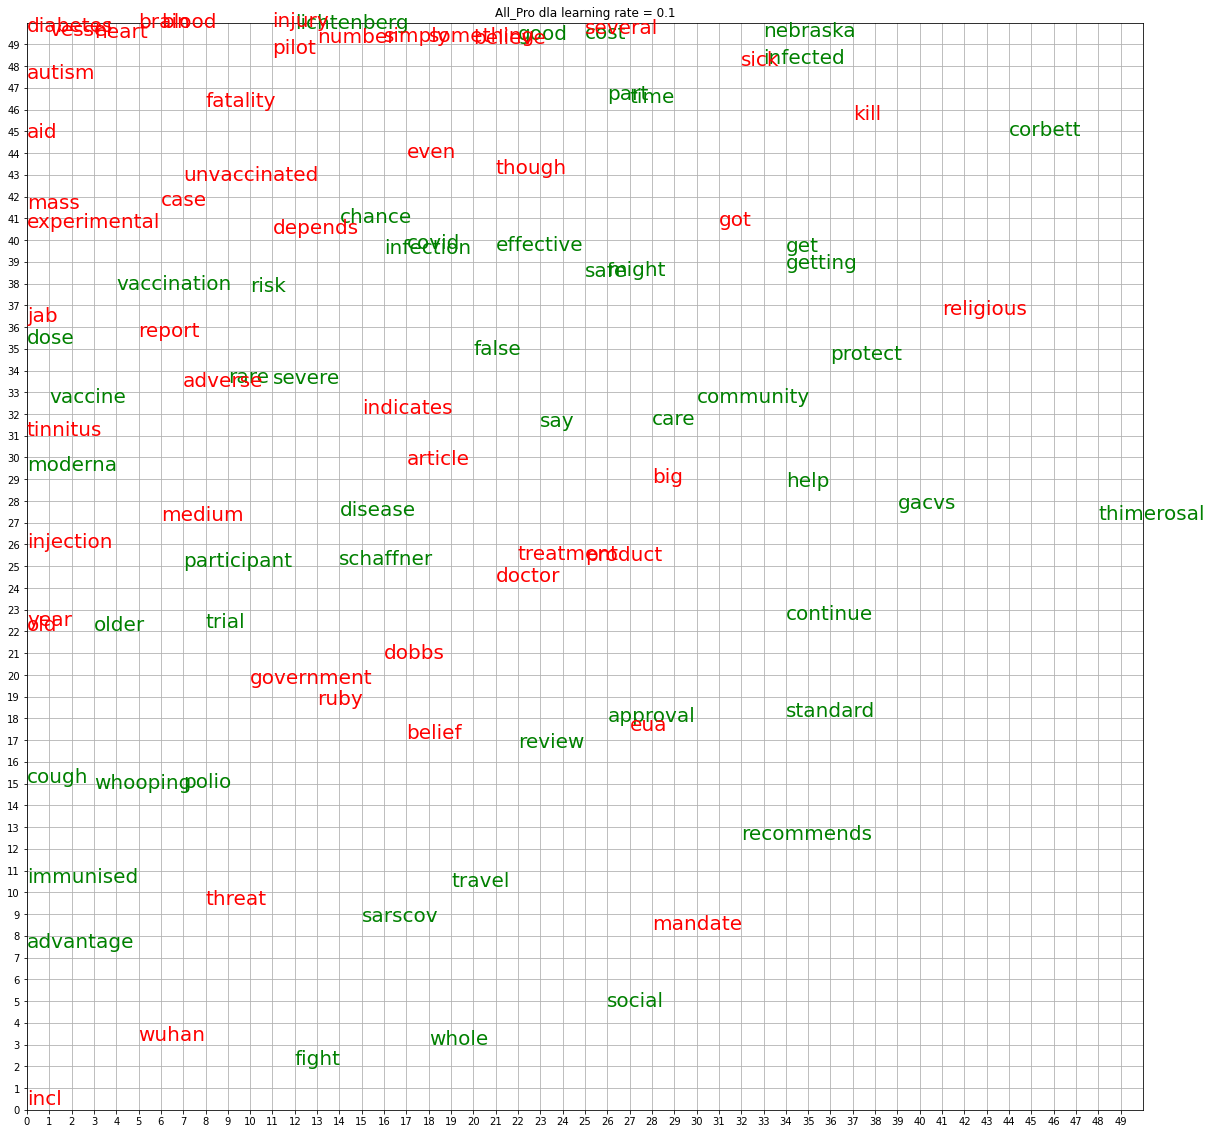

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8495036901106785


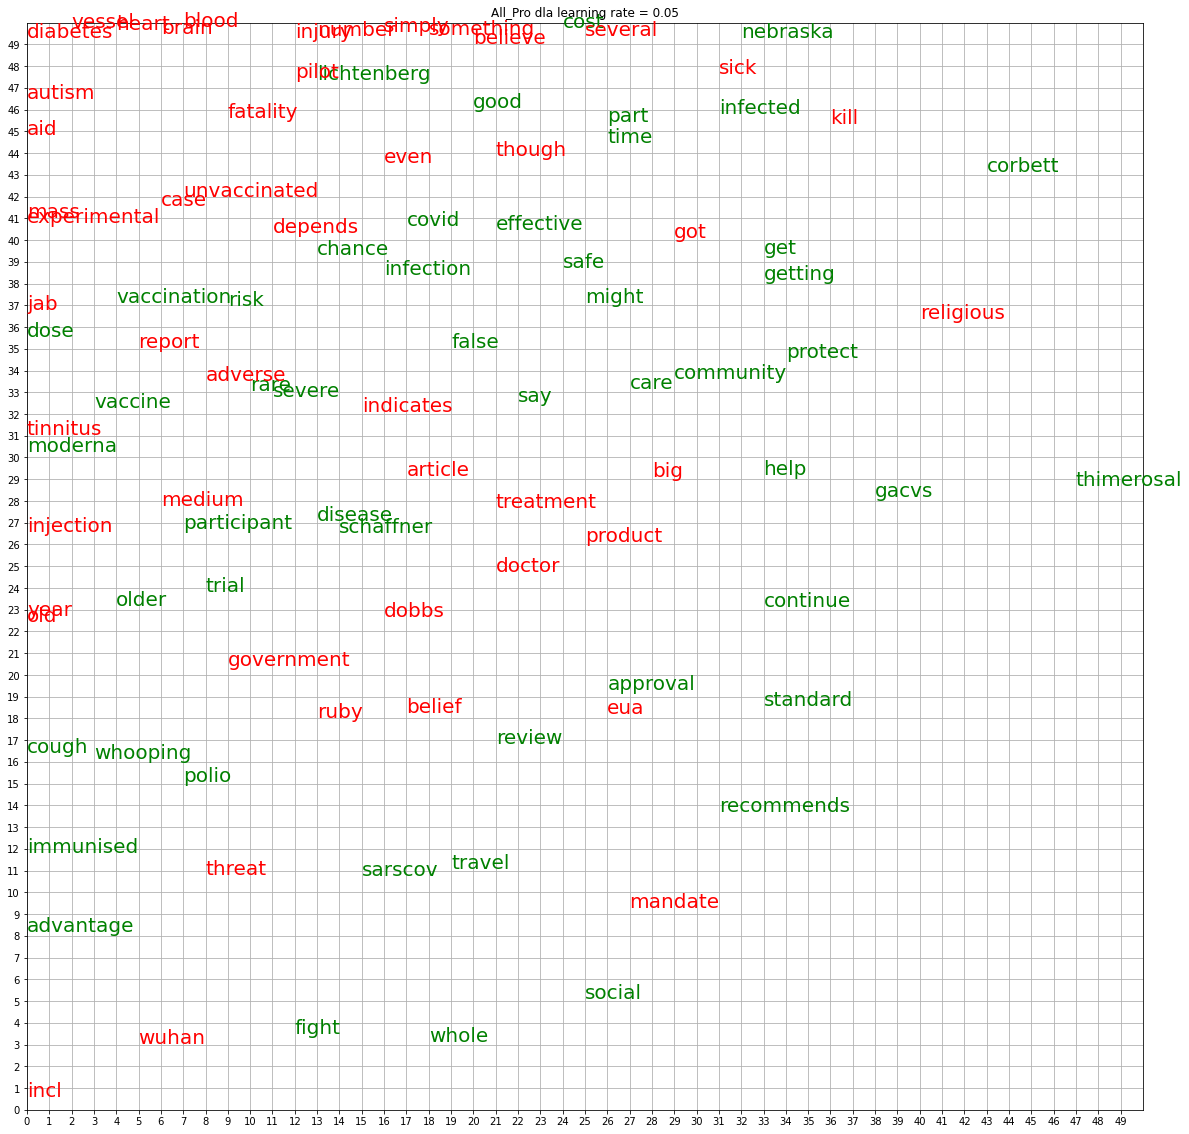

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.7801695181783415


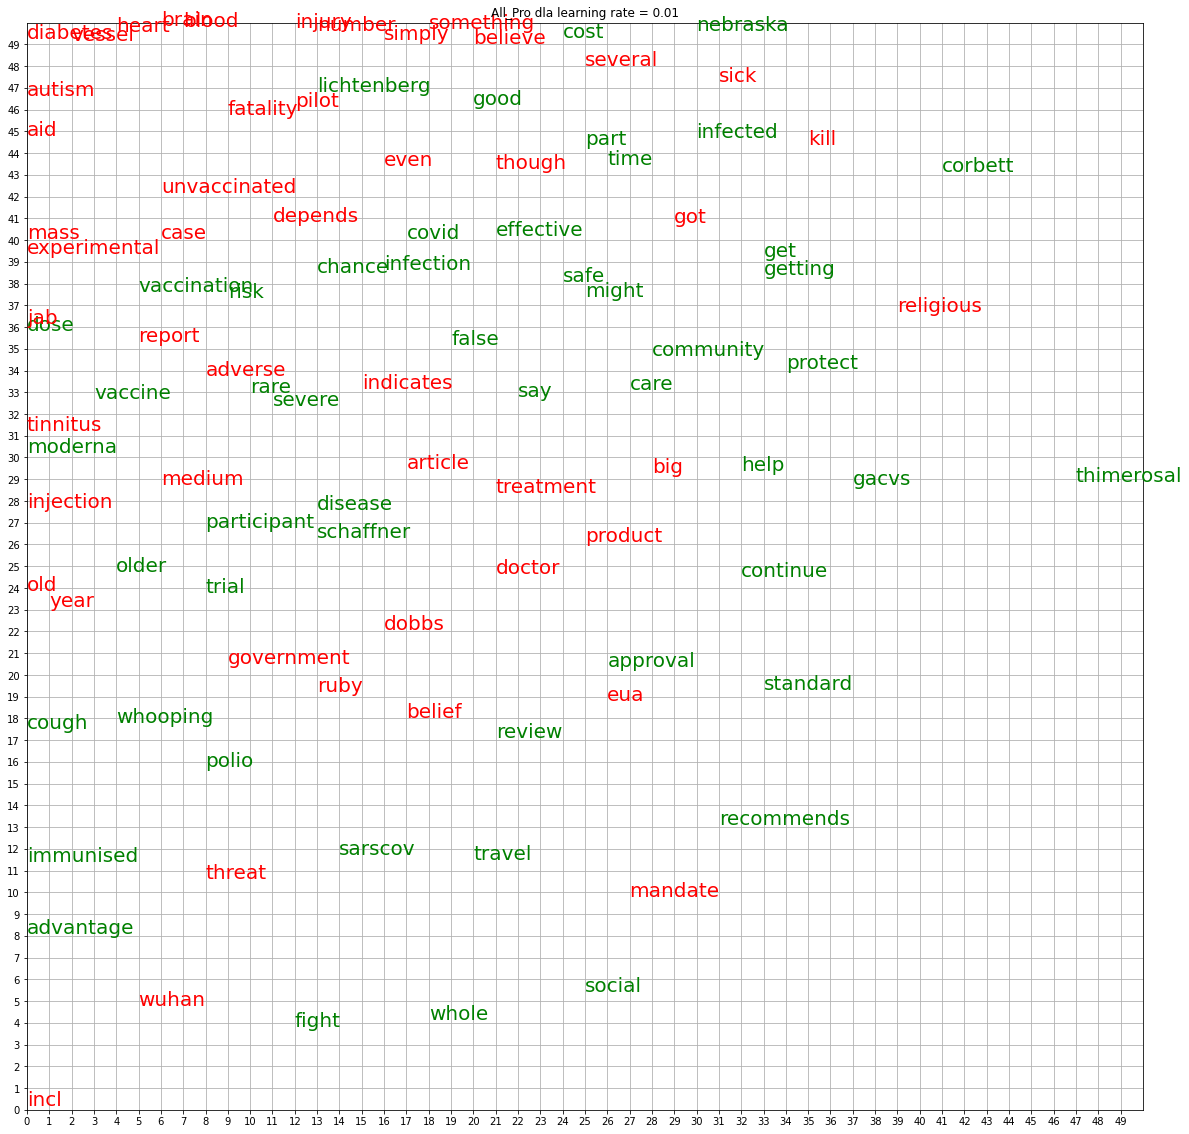

In [30]:
knowledge_init(all_person,all_knowledge_data,"All_Knowledge")
to_read,_ = random_percent(pro_read_data,0.8)
new_simulation(all_person,all_knowledge_data+to_read,"All_Pro")

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8039397990389903


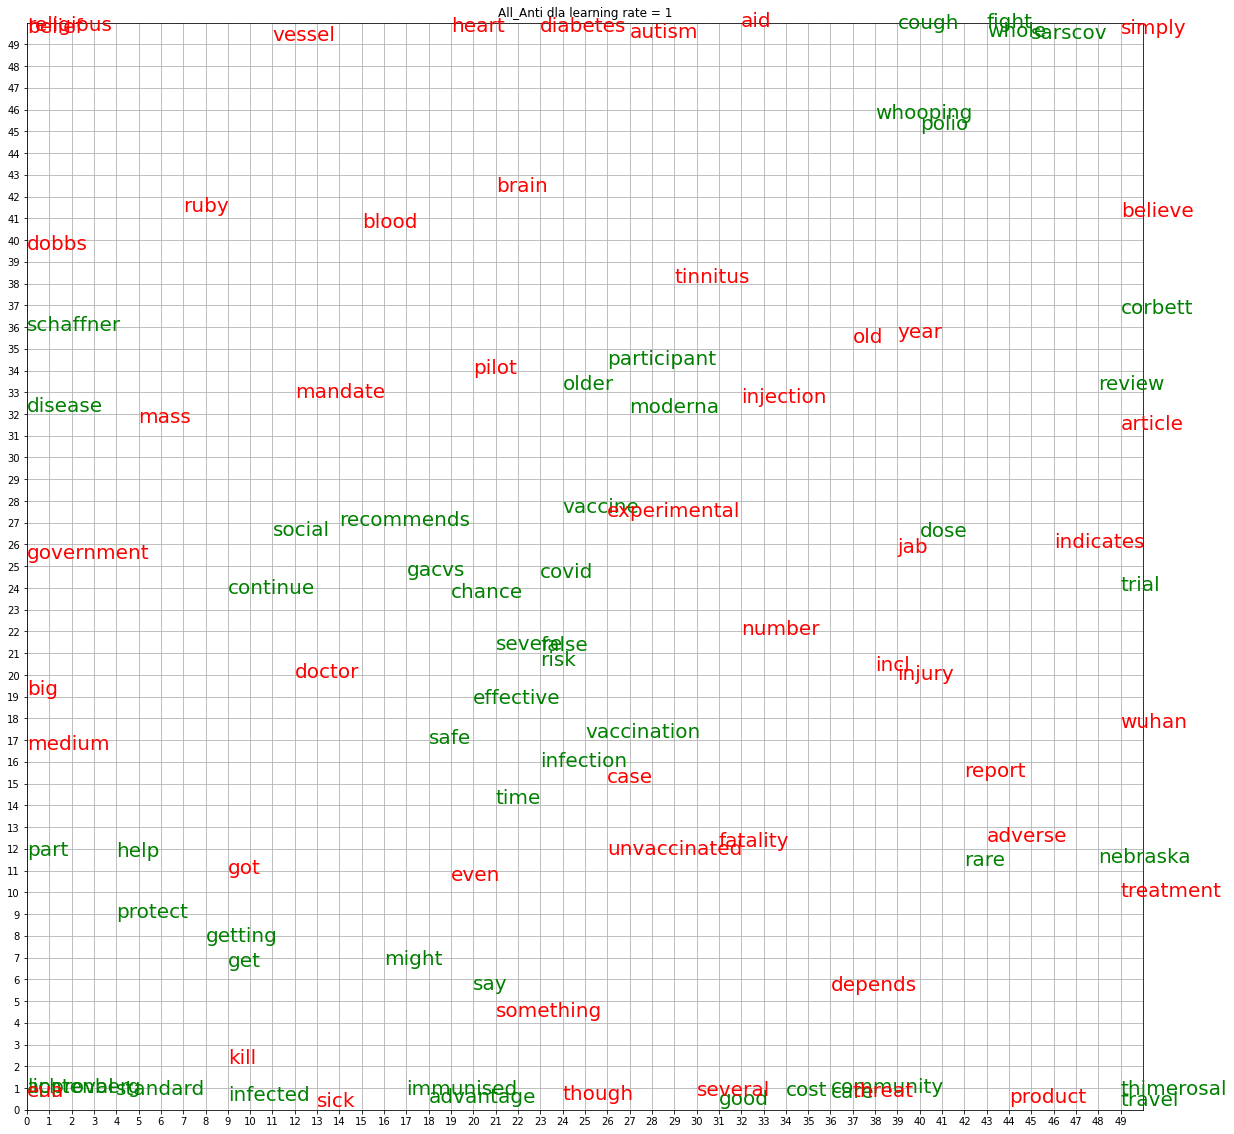

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8288480515847515


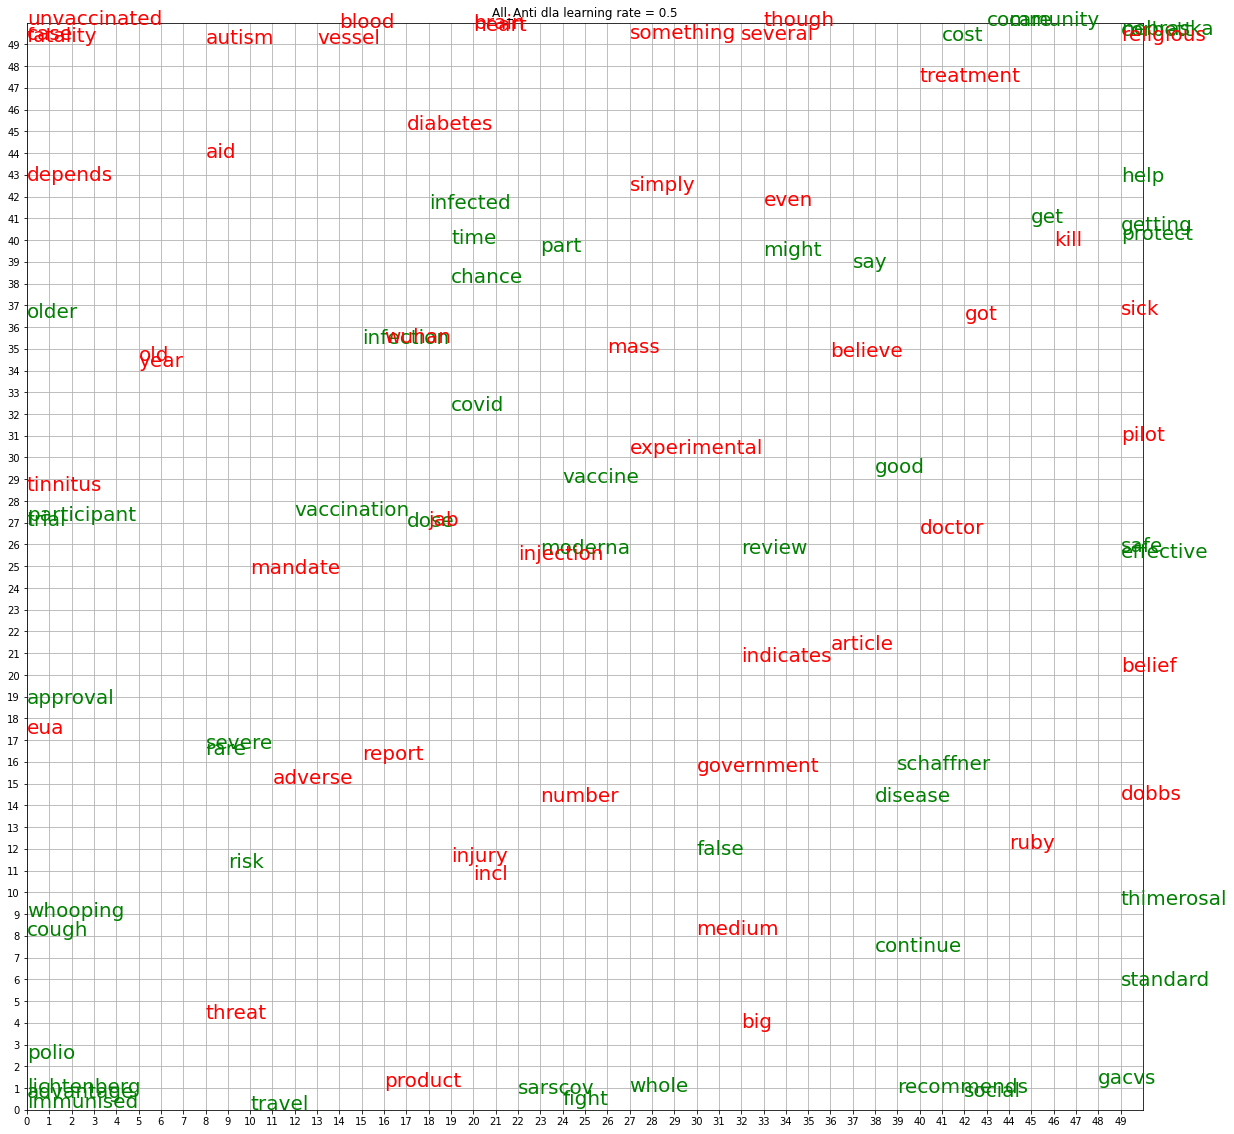

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8602272471950887


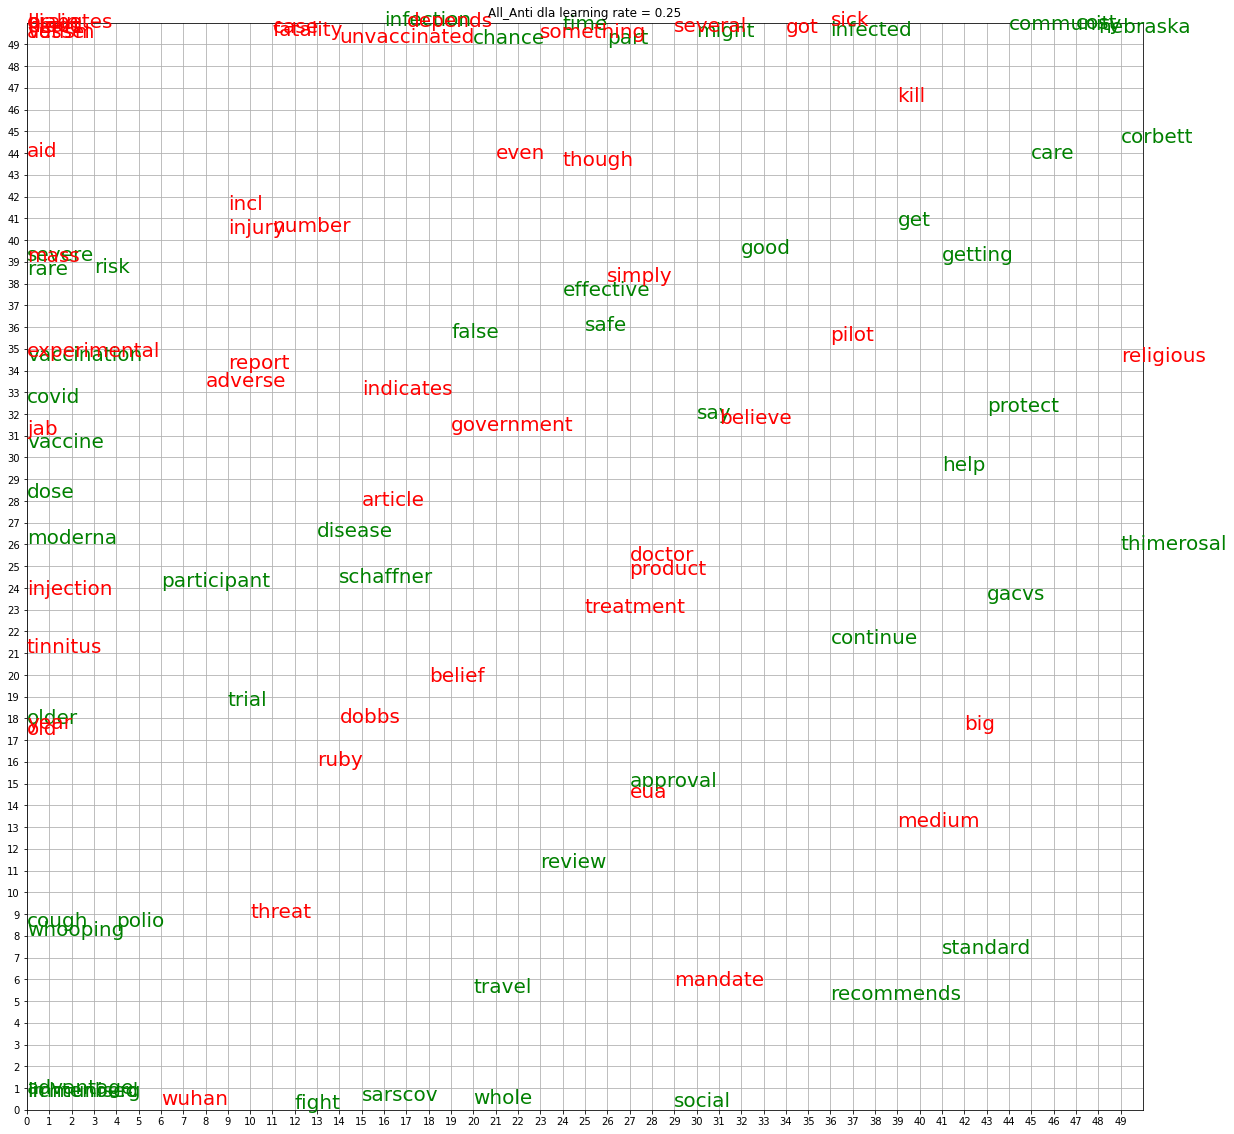

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8768417947024331


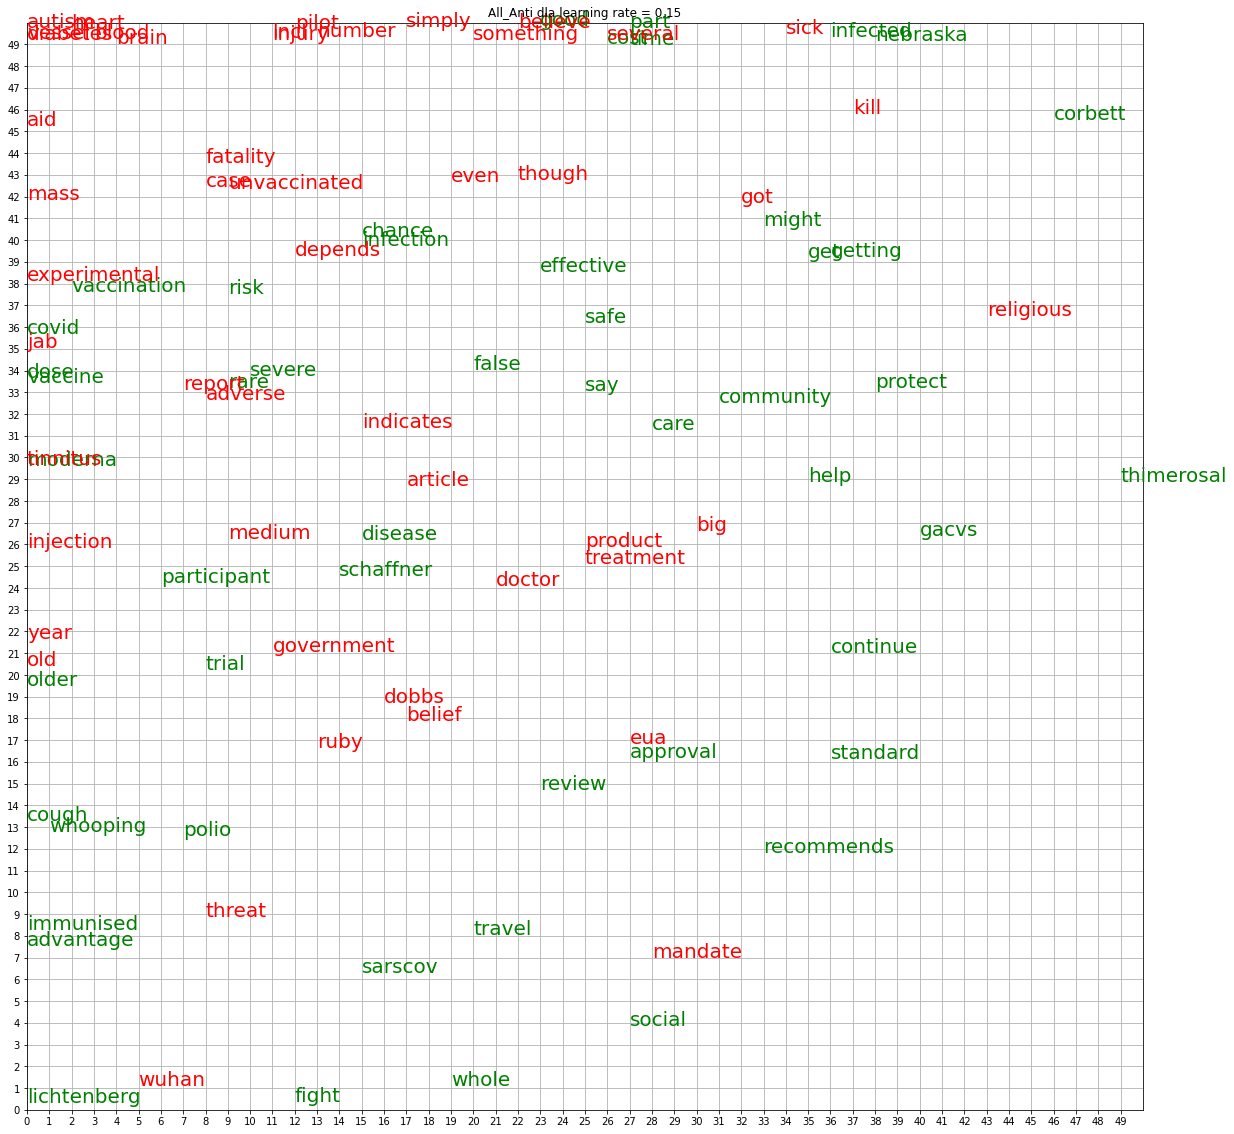

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8746802276622927


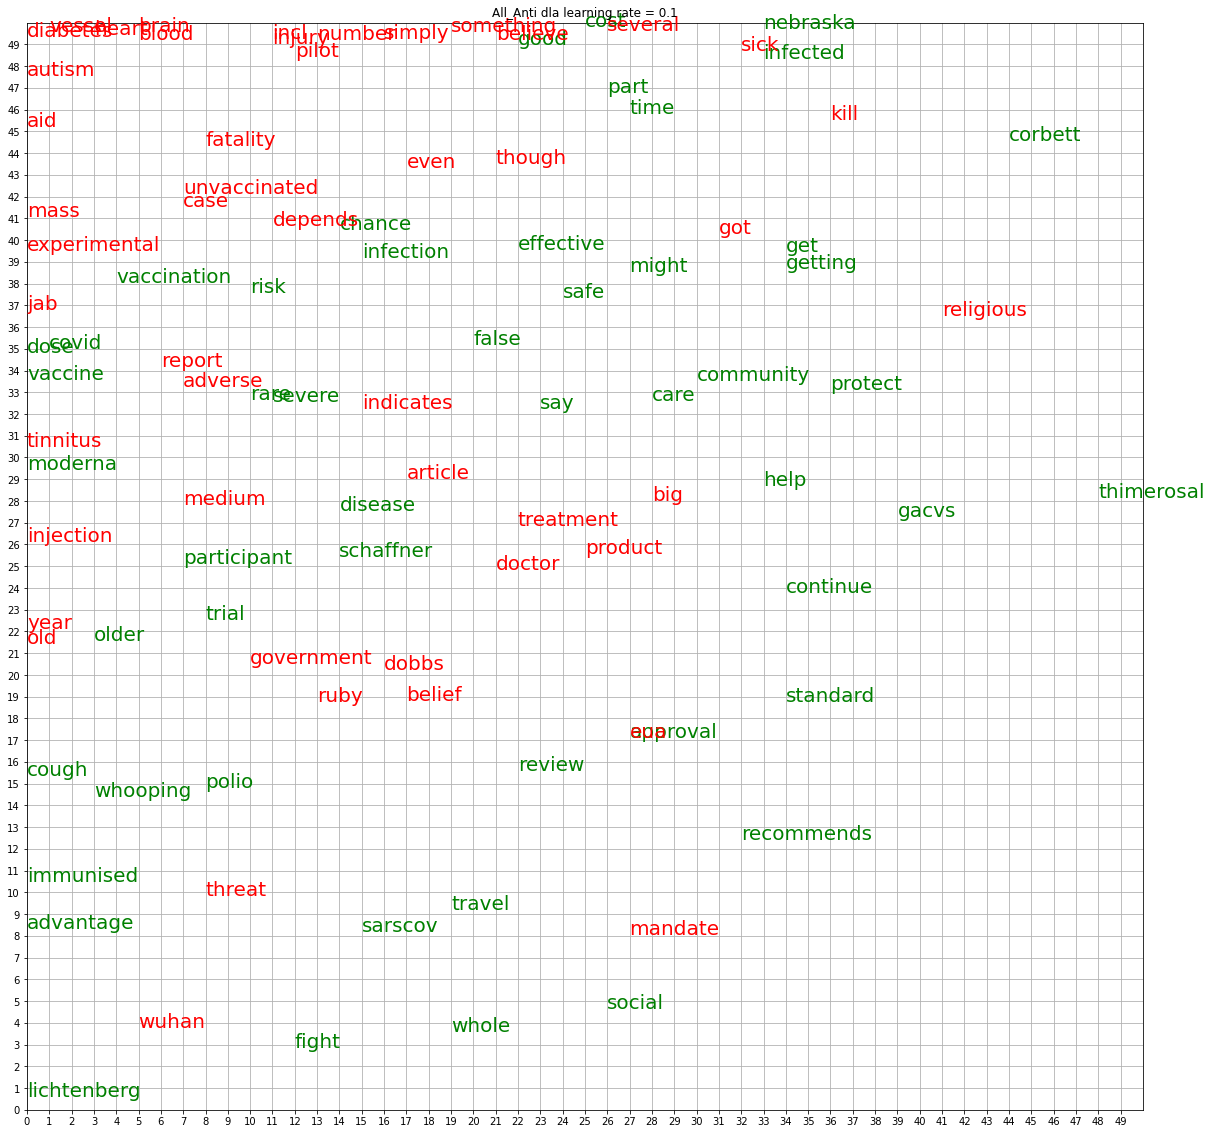

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.8474300951399999


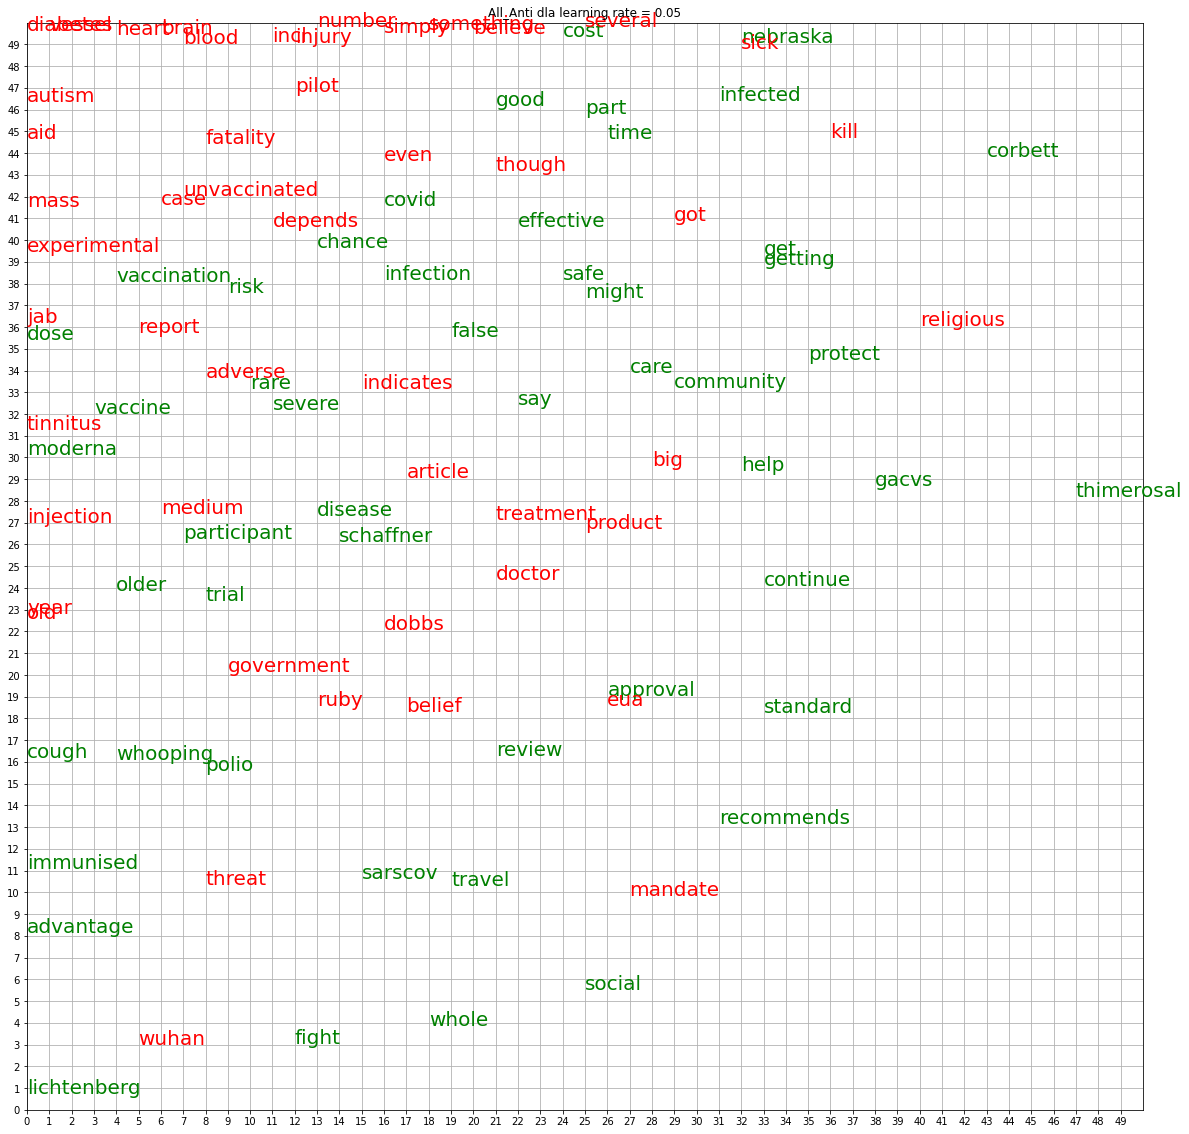

 [ 200 / 200 ] 100% - 0:00:00 left 
 quantization error: 0.7799206909901056


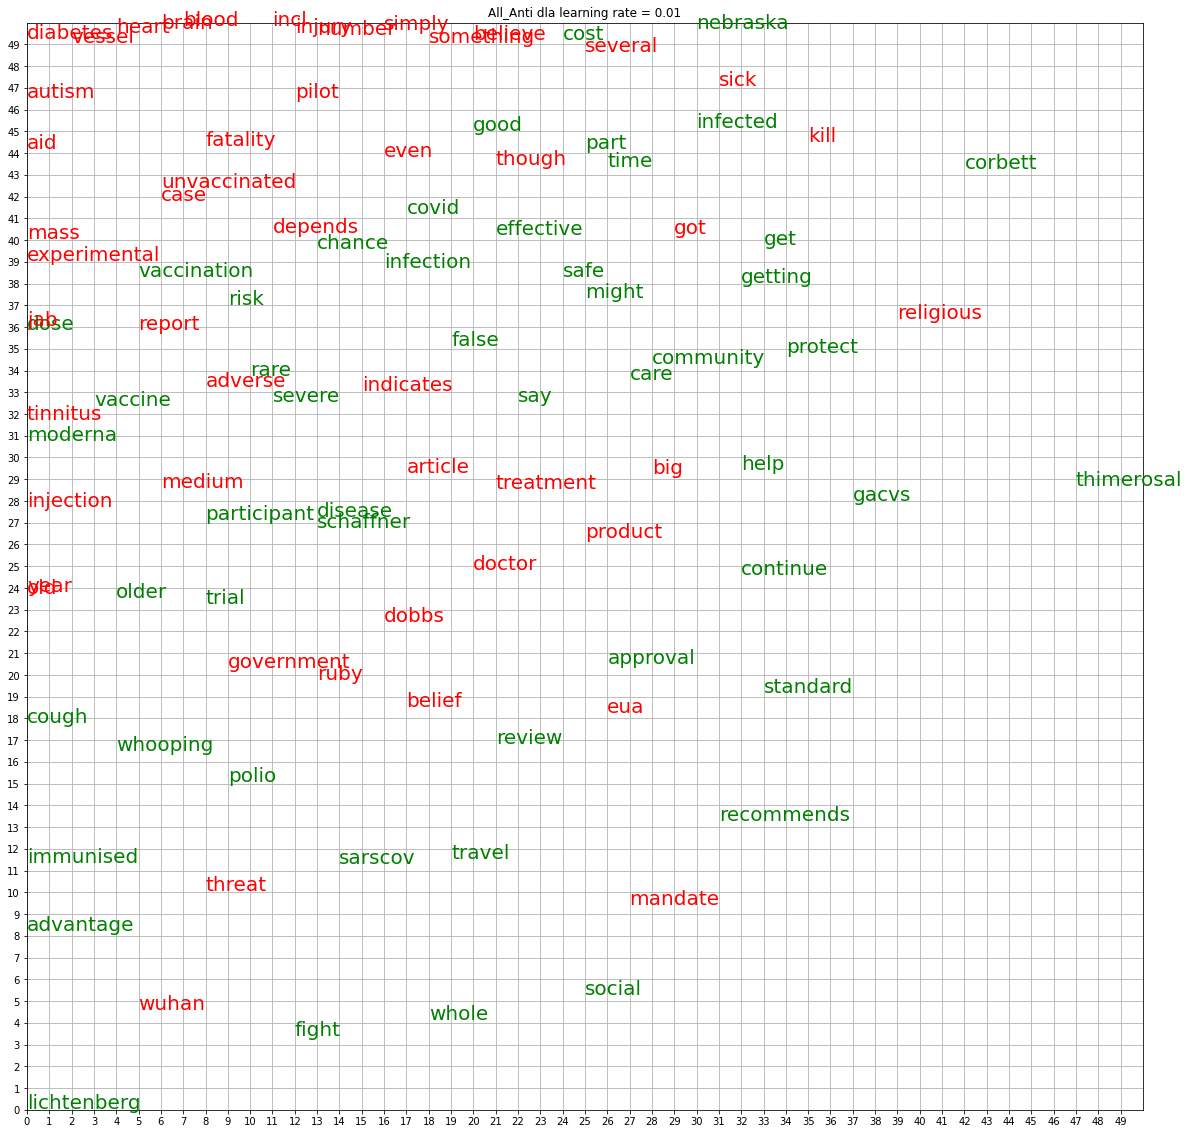

In [31]:
to_read,_ = random_percent(anti_read_data,0.8)
new_simulation(all_person,all_knowledge_data+to_read,"All_Anti")